# Chaos Game Representation

In [1]:
# run this code block before executing the rest of the notebook
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import random
import csv
import sympy
from sympy.ntheory.continued_fraction import continued_fraction_iterator
import skimage.io
from skimage.metrics import structural_similarity as ssim
import pickle
import seaborn as sns
import pandas as pd
from sklearn import manifold, decomposition
import multiprocessing as mp

## Introduction
```{epigraph}
A heavy warning used to be given [by lecturers] that pictures are not rigorous; this has never had its bluff called and has permanently frightened its victims into playing for safety. Some pictures, of course, are not rigorous, but I should say most are (and I use them whenever possible myself).

-- [J.E. Littlewood](https://mathshistory.st-andrews.ac.uk/Biographies/Littlewood/),  {cite:p}`littlewood1986littlewood`(p. 53) 
```

Finding hidden patterns in long sequences can be both difficult and valuable. Representing these sequences in a visual way can often help. The human brain is very adept at detecting patterns visually. Indeed, sometimes _too_ adept: when humans detect spurious patterns that _aren't_ really there, it's called _pareidolia_. That human tendency is what originally provoked the "heavy warning" against pictures that Littlewood complained about above. Nonetheless, pictures can help a lot, to generate conjectures, and sometimes even indicate a path towards a proof, even if sometimes "only" an experimental proof using comparison with data.

The so-called chaos game representation (CGR) of a sequence of integers is a particularly useful technique for pattern detection, which visualizes a one-dimensional sequence in a two-dimensional space. The CGR is presented as a scatter plot, most frequently on a square in which each corner represents an element that appears in the sequence. The results of these CGRs can look like fractals, but even so can be visually recognizable and distinguishable from each other. Interestingly, the distinguishing characteristics can sometimes be made _quantitative_, with a good notion of "distance between images." This is an indirect way of constructing an equivalent notion of "distance between sequences," but it turns out to be simpler to think about.

There is an excellent [video by Robin Truax on CGR and Sierpinksi's triangle](https://youtu.be/5nuYD2M2AX8); worth watching now, or you can save it for later.  Now back to our unit. 

Many applications, such as analysis of DNA sequences {cite:p}`goldman1993nucleotide, jeffrey1990chaos, jeffrey1992chaos, karamichalis2015investigation` and protein structure {cite:p}`basu1997chaos, fiser1994chaos`, have shown the usefulness of CGR and the notion of "distance between images"; we will discuss these applications briefly in {ref}`sec:DNA`. Before that, in {ref}`sec:ifs`, we will look at a random iteration algorithm for creating fractals. In {ref}`sec:math`, we will apply CGR to simple abstract mathematical sequences, including the digits of $\pi$ and the partial quotients of continued fractions. Additionally, we will look at certain "distances between images" that are produced. Finally, we will explain how some of the patterns arise, and what these depictions can indicate to us, or sometimes even tell us rigorously, about the sequences.

One important pedagogical purpose of this module is to provoke a discussion about randomness, or what it means to be random. In this paper, we at first use the word "random" very loosely, on purpose.  Indeed, we will use several words loosely, such as "fractal" and "attractor" or "attracting set". We promise to provide references at the end that will provide more careful definitions, and tighten up the discussion.

```{epigraph}
What is probability? I asked myself this question many years ago, and found that various authors gave different answers. I found that there were several main schools of thought with many variations.

-- [Richard W. Hamming](http://mathshistory.st-andrews.ac.uk/Biographies/Hamming.html), {cite:p}`hamming1991art`
```

```{figure} ../Figures/CGR/HUMHBB_crop.png
---
height: 300px
name: cgr_globin
---
DNA of human beta globin region on chromosome 11 (HUMHBB)---73308 bps
```

__A Note to the Student/Reader__

__A Note to the Instructor__

(sec:ifs)=
## Creating Fractals using Iterated Function Systems (IFS)
One random iteration algorithm for creating pictures of fractals uses the fixed attracting set of an _iterated function system_ (IFS). Before defining IFS, we will first define some necessary preliminaries.

### Affine Transformation in the Euclidean Plane
We write a two dimensional _affine_ transformation in the Euclidean plane $w: \mathbb{R}^{2} \to \mathbb{R}^{2}$ in the form
\begin{equation*}
	w(x_{1}, x_{2}) = \left(ax_{1} + bx_{2} + e, cx_{1} + dx_{2} + f \right)
\end{equation*}
where $a$, $b$, $c$, $d$, $e$, and $f$ are real numbers {cite:p}`barnsley2014fractals`. We will use the following more compact notation:

$$
\begin{align}
	w(x) &= 
	w
	\begin{pmatrix}
		x_{1} \\
		x_{2}
	\end{pmatrix}
	=
	\begin{bmatrix}
		a & b \\
		c & d
	\end{bmatrix}
	\begin{bmatrix}
		x_{1} \\
		x_{2}
	\end{bmatrix}
	+
	\begin{bmatrix}
		e \\
		f
	\end{bmatrix} \nonumber \\ 
	&= Ax + t .
	\label{eqn:ifs} 
\end{align}
$$(eqn-ifs)

The matrix $A$ is a $2 \times 2$ real matrix and can always be written in the form

$$
	\begin{bmatrix}
		a & b \\
		c & d
	\end{bmatrix}
	=
	\begin{bmatrix}
		r_{1}\cos\theta_{1} & -r_{2}\sin\theta_{2} \\
		r_{1}\sin\theta_{1} & \phantom{-}r_{2}\cos\theta_{2}
	\end{bmatrix} ,
	\label{eqn:tmatrix}
$$

where $\left(r_{1}, \theta_{1}\right)$ are the polar coordinates of the point $\left(a, c\right)$ and $\left(r_{2}, \left(\theta_{2} + \frac{\pi}{2}\right)\right)$ are the polar coordinates of the point $\left(b, d\right)$. An example of a _linear_ transformation
\begin{equation*}
	\begin{bmatrix}
		x_{1} \\
		x_{2}
	\end{bmatrix}
	\to
	A
	\begin{bmatrix}
		x_{1} \\
		x_{2}
	\end{bmatrix}
\end{equation*}
in $\mathbb{R}^{2}$ is shown in in the following figure. We can see from this figure that the original shape remains as a parallelogram, but now has changed in size and in rotation. This is what we mean by _linear_ transformation.

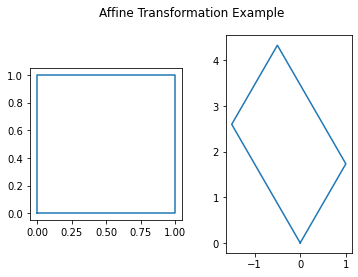

In [2]:
p = np.array([[0, 0, 1, 1, 0], [0, 1, 1, 0, 0]])
t = np.array([[2*math.cos(math.pi/3), -3*math.sin(math.pi/6)], [2*math.sin(math.pi/3), 3*math.cos(math.pi/6)]])
A = np.matmul(t, p)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Affine Transformation Example')
ax1.plot(p[0, :], p[1, :])
ax1.set_aspect('equal', 'box')
ax2.plot(A[0, :], A[1, :])
ax2.set_aspect('equal', 'box')
plt.show()

### Iterated Function System
An _iterated function system_ (IFS)[^1] is a finite set of contraction mappings on a metric space.  These can be used to create pictures of fractals. These pictures essentially show what is called the attractor of the IFS. We will be defining what an attractor is in {ref}`sec:chaos`. In this paper, we will only be looking at the form where each contraction mapping is an affine transformation on the metric space $\mathbb{R}^2$. 

We will illustrate the algorithms for an IFS as an example. Consider the following maps:

$$
\begin{align}
	w_1(x, y) &=
	\left[
		\begin{array}{cc}
			\frac{1}{2} & 0 \\
			0 & \frac{1}{2}
		\end{array}
	\right]
	\left[
		\begin{array}{c}
			x \\
			y
		\end{array}
	\right] 
	+
	\left[
		\begin{array}{c}
			0 \\
			0
		\end{array}
	\right] , \nonumber \\
	w_2(x, y) &=
	\left[
		\begin{array}{cc}
			\frac{1}{2} & 0 \\
			0 & \frac{1}{2}
		\end{array}
	\right]
	\left[
		\begin{array}{c}
			x \\
			y
		\end{array}
	\right]
	+
	\left[
		\begin{array}{c}
			0 \\
			\frac{1}{2}
		\end{array}
	\right] , \nonumber \\
	w_3(x, y) &=
	\left[
		\begin{array}{cc}
			\frac{1}{2} & 0 \\
			0 & \frac{1}{2}
		\end{array}
	\right]
	\left[
		\begin{array}{c}
			x \\
			y
		\end{array}
	\right]
	+
	\left[
		\begin{array}{c}
			\frac{1}{2} \\
			\frac{1}{2}
		\end{array}
	\right] ,
	\label{eqn:sierpinski}
\end{align}
$$(eqn-sierpinski)

each with the _probability factor_ of $\frac{1}{3}$. These values can also be displayed as a table, where the order of the coefficients $a$ through $f$ corresponds to the order presented in Equation {eq}`eqn-ifs` and $p$ represents the probability factor. The corresponding table for Equation {eq}`eqn-sierpinski` can be found in {numref}`IFS_sierpinski`.

```{table} IFS to produce a Sierpinski triangle
:name: IFS_sierpinski
| w | a             | b   | c   | d             | e             | f             | p             |
|---|---------------|-----|-----|---------------|---------------|---------------|---------------|
| 1 | $\frac{1}{2}$ | $0$ | $0$ | $\frac{1}{2}$ | $0$           | $0$           | $\frac{1}{3}$ |
| 2 | $\frac{1}{2}$ | $0$ | $0$ | $\frac{1}{2}$ | $0$           | $\frac{1}{2}$ | $\frac{1}{3}$ |
| 3 | $\frac{1}{2}$ | $0$ | $0$ | $\frac{1}{2}$ | $\frac{1}{2}$ | $\frac{1}{2}$ | $\frac{1}{3}$ |

```

To create a fractal picture using IFS, we first choose a starting point $(x_0, y_0)$. We then _randomly_ choose a map from our IFS and evaluate it at our starting point $(x_0, y_0)$ to get our next point $(x_1, y_1)$. We do this again many times (determined by the user) until we see a pattern. The Python code shown below computes and plots 50000 points corresponding to the IFS from {numref}`IFS_sierpinski`. To choose which map to use for each iteration, we used a uniform random number generator `random.randint` to choose a number between (and including) 0 and 2. Each value corresponds to a map in our IFS. It is clear that the resulting figure shows a fractal, which appears to be[^2] the Sierpinski triangle {cite:p}`barnsley2014fractals, feldman2012chaos`, where its three vertices are located at $(0, 0)$, $(0, 1)$ and $(1, 1)$.

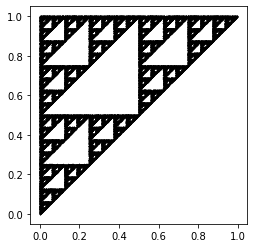

In [3]:
n = 50000
pts = np.zeros((2, n))
rseq = [random.randint(0, 2) for x in range(n-1)]
for i in range(1, n):
    if rseq[i-1] == 0:
        pts[:, i] = np.array([[0.5, 0], [0, 0.5]]).dot(pts[:, i-1]) + np.array([0, 0])
    elif rseq[i-1] == 1:
        pts[:, i] = np.array([[0.5, 0], [0, 0.5]]).dot(pts[:, i-1]) + np.array([0, 0.5])
    else:
        pts[:, i] = np.array([[0.5, 0], [0, 0.5]]).dot(pts[:, i-1]) + np.array([0.5, 0.5])
plt.plot(pts[0, :], pts[1, :], 'k.', markersize=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Iterated function systems can be quite versatile; a set of several attractors can be used to create different shapes and even can resemble real-life objects. An example of this is Barnsley's fern, which resembles the Black Spleenwort {cite:p}`barnsley2014fractals` (see {numref}`black_spleenwort`). The map is displayed in the following table:

| w | a     | b     | c     | d    | e    | f    | p    |
|---|-------|-------|-------|------|------|------|------|
| 1 | 0.00  | 0.00  | 0.00  | 0.16 | 0.00 | 0.00 | 0.01 |
| 2 | 0.85  | 0.04  | -0.04 | 0.85 | 0.00 | 1.60 | 0.85 |
| 3 | 0.20  | -0.26 | 0.23  | 0.22 | 0.00 | 1.60 | 0.07 |
| 4 | -0.15 | 0.28  | 0.26  | 0.24 | 0.00 | 0.44 | 0.07 |

We can use Python to produce the plot of the IFS given above.

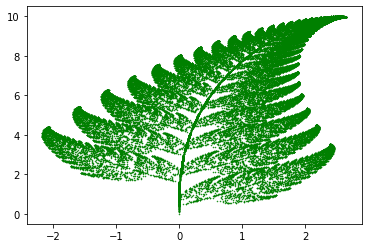

In [4]:
n = 50000

fern = np.zeros((2, n))

for i in range(1, n):
    r = random.random()
    if r <= 0.01:
        fern[:, i] = np.array([[0, 0], [0, 0.16]]).dot(fern[:, i-1])
    elif r <= 0.86:
        fern[:, i] = np.array([[0.85, 0.04], [-0.04, 0.85]]).dot(fern[:, i-1]) + np.array([0, 1.6])
    elif r <= 0.93:
        fern[:, i] = np.array([[0.2, -0.26], [0.23, 0.22]]).dot(fern[:, i-1]) + np.array([0, 1.6])
    else:
        fern[:, i] = np.array([[-0.15, 0.28], [0.26, 0.24]]).dot(fern[:, i-1]) + np.array([0, 0.44])

plt.plot(fern[0, :], fern[1, :], 'g.', markersize=1)
plt.show()

```{figure} ../Figures/CGR/black_spleenwort.jpg
---
height: 200px
name: black_spleenwort
---
Comparison of Barnsley's Fern to the black spleenwort, which is what the IFS was based on.
```

(CGRActivity-1)=

```{admonition} CGR Activity 1
:class: tip
Playing with the coefficients of the transformation functions will create mutate fern varieties. One example of a mutant has the following IFS

| **w** | **a** | **b** | **c**  | **d** | **e**  | **f** | **p** |
|-------|-------|-------|--------|-------|--------|-------|-------|
| 1     | 0.00  | 0.00  | 0.00   | 0.25  | 0.00   | -0.4  | 0.02  |
| 2     | 0.95  | 0.005 | -0.005 | 0.93  | -0.002 | 0.5   | 0.84  |
| 3     | 0.035 | -0.2  | 0.16   | 0.04  | -0.09  | 0.02  | 0.07  |
| 4     | -0.04 | 0.2   | 0.16   | 0.04  | 0.083  | 0.12  | 0.07  |

a) Modify the given Barnsley fern code to create the mutant given by the IFS above. What are the differences between the original Barnsley fern and the mutant? {ref}`[What happened when we did this] <CGRActivityReport-1a>`

b) Create your own Barnsley fern mutate by changing the coefficients. {ref}`[What happened when we did this] <CGRActivityReport-1b>`
```

(CGRActivity-2)=

```{admonition} CGR Activity 2
:class: tip

__Activity 2:__ [Paul Bourke's website](http://paulbourke.net/fractals/ifs/) provides several images produced by IFS. Replicate some of these examples using Python. {ref}`[What happened when we did this] <CGRActivityReport-2>`
```

(sec:chaos)=
## Chaos Game
CGR is based on a technique from chaotic dynamics called the "chaos game"[^3], popularized by Barnsley {cite:p}`barnsley2014fractals` in 1988. The chaos game is an algorithm which allows one to produce pictures of fractal structures {cite:p}`jeffrey1990chaos`. In its simplest form, this can be demonstrated with a piece of paper and pencil using the following steps (adapted from {cite:p}`jeffrey1990chaos`):

1. On a piece of paper, draw three points spaced out across the page; they do not necessarily need to be spaced out evenly to form an equilateral triangle though they might be.  These will determine the "_gameboard_", where the picture will ultimately lie.
2. Label one of the points with "1, 2", the other point with "3, 4", and the last point with "5, 6".
3. Draw a point anywhere on the page: this will be the starting point.
4. Roll a six-sided die. Draw an imaginary line from the current dot towards to the point with the corresponding number, and put a dot half way on the line. This becomes the new "current dot".
5. Repeat step 4 (until you get bored).

Obviously, one would not want to plot a large number of points by hand[^4]; instead, this can be done by computer; the code is shown below. For this algorithm, we assigned $(0, 0)$, $(0, 1)$ and $(1, 1)$ as the vertices of the triangle; they each are labelled with the value $0$, $1$, and $2$, respectively. Instead of using a die to decide which vertex to choose, similarly to the above code, we use the built-in function `random.randint`, which picks from the set $\{0, 1, 2\}$. 

To calculate the new point, we take the average between the previous point and the corresponding vertex. For example, if the first random number generated was $2$, then we would take the average between our initial point (0, 0) and the vertex that corresponds to $2$, which is in our case is $(1, 1)$. Our new point would be $(0.5, 0.5)$. We then would repeat this process until one decides to stop.

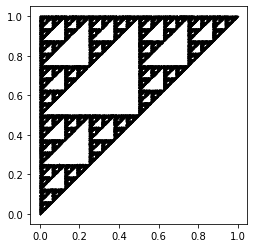

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random

n = 50000
pts = np.zeros((2, n))
rseq = [random.randint(0, 2) for x in range(n-1)]
for i in range(1, n):
    if rseq[i-1] == 0:
        pts[:, i] = 0.5*(pts[:, i-1] + np.array([0, 0])) 
    elif rseq[i-1] == 1:
        pts[:, i] = 0.5*(pts[:, i-1] + np.array([0, 1])) 
    else:
        pts[:, i] = 0.5*(pts[:, i-1] + np.array([1, 1]))
        
plt.plot(pts[0, :], pts[1, :], 'k.', markersize=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

One would expect that the outcome above would show that the dots would appear randomly across the gameboard; however, this is not the case: the figure shows the result of the chaos game if the game was played 50000 times. We can see that this figure shows a fractal-like pattern (such as one of a Sierpinski triangle), and looks almost (if not) identical to the figure which resulted from the IFS.

It is quite interesting that a sequence of random numbers could produce such a distinct pattern. Indeed, some bad _pseudorandom number generators_ were identified as being bad precisely because they failed a similar-in-spirit visualization test {cite:p}`knuth1997seminumerical`. We will discuss this issue further in {ref}`sec:random`. However, what has happened here is that the _randomness_ of the sequence has translated into a _uniform_ distribution _on the fractal_. So, really, here the gameboard is the fractal! We will return to this point in the next section.

{numref}`sierpinski_steps` shows an example of the first five steps of the chaos game (overlaid on top of a CGR with 10000 points), which corresponds to the following values that were randomly generated: 2, 1, 0, 0, 2. Displaying the CGR in this manner can give us some insight as to why this particular chaos game with three vertices gives us such a striking fractal: we can see from the figure that each of the points from the first five steps is located at a vertex (in this case the right-angled one) of one of the many triangles within the fractal. A careful observer would notice that the triangle at which the point is located becomes smaller each iteration. This implies that within the next few iterations, the triangle associated with the computed point would be too small to be seen in this illustration. [Note: if we zoom into that microscopic level, the dots would look random. Indeed, the random dots are ultimately dense on the Sierpinski triangle.] This sequence of points generated by the chaos game is called the _orbit_ of the seed and it is attracted to the Sierpinski triangle. For another description of why this chaos game creates the Sierpinski triangle, see {cite:p}`fisher2012science`.

```{figure} ../Figures/CGR/sierpinski_steps.png
---
height: 300px
name: sierpinski_steps
---
First 5 steps of chaos game with three vertices. In this example, the first 5 random integers generated are 2, 1, 0, 0, 2.
```

### Generalization of CGR
We have already seen that a fractal pattern can appear when we follow the chaos game described above for a polygon with three vertices (triangle) using a random number generator, but we are not limited to only this. There are many variations for CGR, and some are more useful than others. In this section, we will look into what patterns arise when we perform CGR on different polygons, changing the placement of the $i$-th point relative to the $(i-1)$-th and its corresponding vertex, and explore which of these could potentially be useful for some applications presented in {ref}`sec:DNA`.

(sec:polygons)=
#### Different Polygons
The figure created from the following code shows the chaos game representation, where the $i$-th point is placed halfway between the $(i-1)$-th point and the vertex corresponding to the $i$-th base, for various polygons, using a sequence of 50,000 uniformly generated (pseudo)random integers. As we can see below, when the CGR is a square, there is no apparent pattern: the chaos game produced a square uniformly (to the eye) filled with points. This particularly conforms to our intuition: a random sequence should _look_ random.  The other polygons appear, in contrast, to exhibit some patterns. These patterns are due to several parts of their attractors overlapping[^5], or failing to overlap at all, indicated by the the uneven distribution of points (where points do appear); i.e. we can see some darker areas and some lighter areas and even gaps in the figures. Therefore, for this particular chaos game (in which we say that the _dividing rate_ $r$ is $0.5$&mdash;we will talk about this in {ref}`sec:dividingrate`), the square is the best choice to visualize one-dimensional sequences. We will see in {ref}`sec:generalization` that we can use other polygons (we will be referring to them as $m$-gons) for CGR to uncover patterns in sequences not with 4 elements by using the appropriate dividing rate $r$: that is, instead of placing a point half-way to the target vertex, we will place it at some other position along the line, with $0 < r < 1$.  A proper choice of $r$ will ensure that a random sequence will generate a uniform density of points, possibly on a fractal.

In [6]:
def n_gon(n, *start):
    if start:
        deg = np.linspace(start[0], start[0] + 360, n+1)
    else:
        deg = np.linspace(0, 360, n+1)
    deg = deg[:-1]
    rad = []
    for d in deg:
        rad.append((d/360)*2*math.pi)
    cor = np.zeros((2, n+1))
    for r in range(len(rad)):
        x = math.cos(rad[r])
        y = math.sin(rad[r])
        cor[:, r] = np.array([x, y])
    cor[:, n] = cor[:, 0]
    return cor

def polyCGR(N, n, *start):
    if start:
        shape_coord = n_gon(n, start[0])
    else:
        shape_coord = n_gon(n)
    dataPoints = np.zeros((2, N))
    for i in range(1, N):
        r = random.random()
        dataPoints[:, i] = 0.5*(dataPoints[:, i-1] + shape_coord[:, math.floor(r*n)])
    return(shape_coord, dataPoints)

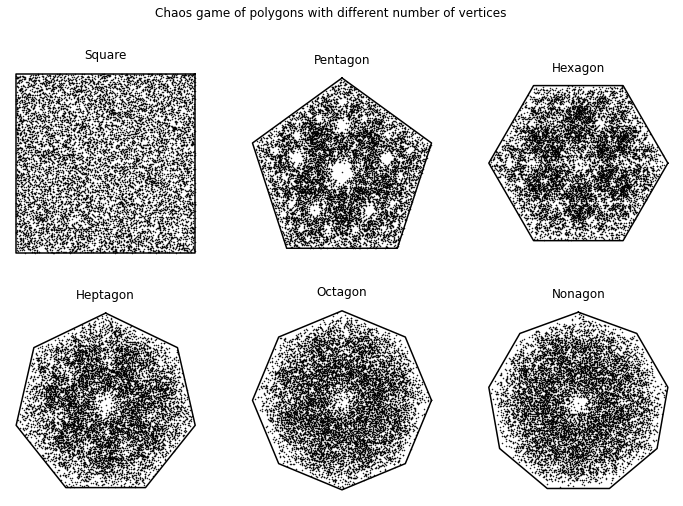

In [7]:
N = 10000

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Chaos game of polygons with different number of vertices')

(coord, points) = polyCGR(N, 4, 45)
ax1.plot(coord[0, :], coord[1, :], 'k')
ax1.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax1.axis('off')
ax1.set_aspect('equal', 'box')
ax1.set_title('Square')

(coord, points) = polyCGR(N, 5, 90)
ax2.plot(coord[0, :], coord[1, :], 'k')
ax2.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax2.axis('off')
ax2.set_aspect('equal', 'box')
ax2.set_title('Pentagon')

(coord, points) = polyCGR(N, 6)
ax3.plot(coord[0, :], coord[1, :], 'k')
ax3.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax3.axis('off')
ax3.set_aspect('equal', 'box')
ax3.set_title('Hexagon')

(coord, points) = polyCGR(N, 7, 90)
ax4.plot(coord[0, :], coord[1, :], 'k')
ax4.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax4.axis('off')
ax4.set_aspect('equal', 'box')
ax4.set_title('Heptagon')

(coord, points) = polyCGR(N, 8)
ax5.plot(coord[0, :], coord[1, :], 'k')
ax5.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax5.axis('off')
ax5.set_aspect('equal', 'box')
ax5.set_title('Octagon')

(coord, points) = polyCGR(N, 9, 90)
ax6.plot(coord[0, :], coord[1, :], 'k')
ax6.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax6.axis('off')
ax6.set_aspect('equal', 'box')
ax6.set_title('Nonagon')

plt.show()

(sec:dividingrate)=
#### Dividing Rate
In the previous subsection, we saw different patterns appear for different shapes. We saw that shapes with more than $4$ vertices seemed to have several parts of the attractor overlapping, producing visibly nonuniform density (some areas were visibly darker than others). Here we will show that this attractor overlapping also happens when choosing a _small enough_ dividing rate $r$.

To be explicit, the chaos game is not restricted to the "rule" in which the new point has to be placed halfway between the current point and the corresponding vertex as depicted in the previous examples. The new point can be placed anywhere within the line segment created by the two points of reference (or even outside, if you are willing to let the points land outside the convex hull of the vertices). The placement of the new point affects how the attractor of the CGR looks. We will see this in the following example. To quantify the placement of the point, we take the proportion of which the distance between the new point and current point is from the distance between the current point and the corresponding vertex. This is called the _dividing rate_, $r$. The new point $p_{i+1}$ is thus $p_{i+1} = p_i + r(V-p_i)$. Therefore, when the new point is placed halfway between the current point and the vertex, the dividing rate is $r = 0.5$, and if the new point is placed closer to the location of the current point, then the dividing rate $r < 0.5$, whereas if the point is closer to the vertex, then the dividing rate $r > 0.5$.

To continue this discussion, let us vary $r$ for the square-shaped CGR of a sequence of random integers. As we have seen in the previous subsection, the square-shaped CGR did not exhibit any fractal patterns when $r = 0.5$, so we wondered if we varied $r$, would this change? The following code gives the square CGRs for $r = 0.1, 0.25, 0.4, 0.6, 0.75,$ and $0.9$. From these figures, we see how $r$ affects the visualization. 

In [8]:
def dividingRateCGR(N, r):
    shape_coord = n_gon(4, 45)
    dataPoints = np.zeros((2, N))
    for i in range(1, N):
        rand = random.random()
        dataPoints[:, i] = dataPoints[:, i-1] + (shape_coord[:, math.floor(4*rand)] - dataPoints[:, i-1])*r
    return(shape_coord, dataPoints)

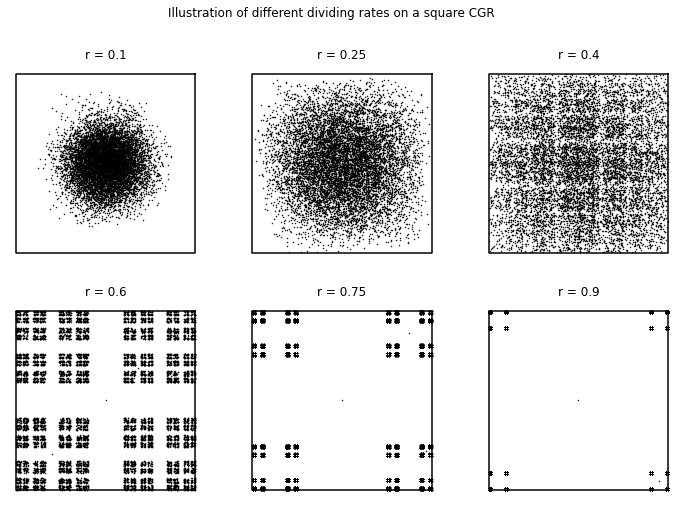

In [9]:
N = 10000

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Illustration of different dividing rates on a square CGR')

(coord, points) = dividingRateCGR(N, 0.1)
ax1.plot(coord[0, :], coord[1, :], 'k')
ax1.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax1.axis('off')
ax1.set_aspect('equal', 'box')
ax1.set_title('r = 0.1')

(coord, points) = dividingRateCGR(N, 0.25)
ax2.plot(coord[0, :], coord[1, :], 'k')
ax2.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax2.axis('off')
ax2.set_aspect('equal', 'box')
ax2.set_title('r = 0.25')

(coord, points) = dividingRateCGR(N, 0.4)
ax3.plot(coord[0, :], coord[1, :], 'k')
ax3.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax3.axis('off')
ax3.set_aspect('equal', 'box')
ax3.set_title('r = 0.4')

(coord, points) = dividingRateCGR(N, 0.6)
ax4.plot(coord[0, :], coord[1, :], 'k')
ax4.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax4.axis('off')
ax4.set_aspect('equal', 'box')
ax4.set_title('r = 0.6')

(coord, points) = dividingRateCGR(N, 0.75)
ax5.plot(coord[0, :], coord[1, :], 'k')
ax5.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax5.axis('off')
ax5.set_aspect('equal', 'box')
ax5.set_title('r = 0.75')

(coord, points) = dividingRateCGR(N, 0.9)
ax6.plot(coord[0, :], coord[1, :], 'k')
ax6.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax6.axis('off')
ax6.set_aspect('equal', 'box')
ax6.set_title('r = 0.9')

plt.show()

For $r < 0.5$, we can see that some patterns appear, especially those with a dividing rate close to $r = 0.5$. More importantly, we see a nonuniformity of distribution in the square.  In contrast, we can see for $r = 0.6$ that the points fill the corners of the plot area, but they are unevenly-spaced (in comparison to what we have seen for $r = 0.5$). This suggests that when $r < 0.5$, the attractors are overlapping, indicated by the darker regions of the plot due to the points being more densely packed, and that when $r>0.5$ the attractor lies on a fractal and is apparently uniformly distributed thereon. For $r$ significantly less than $1/2$, we can see that the CGR becomes more circular with the points spaced more closely together. From this, it infers that as $r$ decreases, more of the attractors overlap.

For $r > 0.5$, we can see that a different pattern appears (compared to those with a dividing rate $r < 0.5$). The patterns shown for the CGRs with a dividing ratio $r > 0.5$ visibly resemble each other. The $r = 0.9$ case looks like a smaller version of the $r = 0.75$ case, which similarly, looks like a sparser version of the $r = 0.6$ case. In contrast to the CGR with the dividing rate $r = 0.5$, we can see that the points are spread apart from each other. This can possibly indicate that the attractors do not overlap, and even do not touch each other. Although this can be used to distinguish any nonrandomness, it would be much more difficult to see with the human eye than using the dividing rate $r = 0.5$.

For applications which need a different number of vertices than $m=4$, it turns out to be optimal to find a dividing rate $r$ for different polygons that can offer maximum packing of nested, non-overlapping attractors, in order to help find a pattern in a given sequence. In the next subsection, we look at this optimal value of $r$ as reported in the literature.

(sec:generalization)=
#### Generalization of CGR
In {cite:p}`fiser1994chaos`, Fiser et al. generalized CGR to be applicable for sequences of any number of elements $m > 2$. There are many ways of generalizing CGR, some of which are highlighted in {cite:p}`almeida2009biological`, but the generalization the authors of the earlier article chose was to use an $m$-sided polygon (which they refer to as an $m$-gon), where $m$ was the number of elements in a sequence that should be represented {cite:p}`fiser1994chaos`. As we saw previously in {ref}`sec:polygons`, the attractors of the $m$-gons for when $m > 4$ and $r=0.5$ overlapped as shown by the uneven distribution of the points. Because of this, the picture is ambiguous and is not as useful to serve as a way to identity patterns in sequences. To combat this, Fiser et al. introduced a formula to calculate the dividing rate for $m$-gons for different values of $m$: by putting each attractor piece inside a non-overlapping circle, they derived
\begin{equation*}
    r = \left(1 + \sin\left(\frac{\pi}{m}\right)\right)^{-1} .
\end{equation*}
Although the dividing rate calculated from this formula does prevent attractors from overlapping, Almeida and Vinga noticed in {cite:p}`almeida2009biological` that the resulting attractors are not optimally packed. For example, for $m = 4$, the solution gives a dividing rate $r = 0.585786$ instead of $r = 0.5$, which works perfectly well (and indeed is maybe better). In {cite:p}`almeida2009biological`, the authors gave a more complicated formula for the dividing rate, which they say they derived by using basic trigonometry to pack polygons (instead of circles) into the outer $m$-gon.
We have simplified their formula considerably
\begin{equation*}
r = 
\frac{\sin \! \left(\frac{(2  k -1)\pi}{m}\right)}{\sin \! \left(\frac{(2 k -1)\pi}{m}\right)+\sin \! \left(\frac{\pi}{m}\right)}
\end{equation*}
where
\begin{equation*}
    k = \mathrm{round}\left(\frac{m+2}{4}\right) .
\end{equation*}
If we use $k= (m+2)/4$ without rounding to an integer, this formula simplifies to the previous one. This fact was not noted in {cite:p}`almeida2009biological`.
We note some special values: when $m=3$ or $m=4$, this formula gives $r=0.5$.  When $m=5$, this formula gives $r = (\sqrt{5}-1)/2 = 0.618\ldots$. Various other $m$ give algebraic values. When $(m+2)/4$ is half-way between integers, either choice of rounding for $k$ gives the same $r$.

The figure created from the following code shows the generalized CGRs for various $m$-gons using the division formula from {cite:p}`fiser1994chaos` (left) and {cite:p}`almeida2009biological` (right).

In [10]:
def dividingRateFiser(n):
    return (1 + math.sin(math.pi/n))**(-1)

def dividingRateAlmeida(n):
    k = round((n+2.)/4.)
    s_num = 2*math.cos(math.pi*((1/2) - (k/n))) - 2*math.cos(math.pi*((1/2)-(1/(2*n))))*math.cos((2*k-1)*(math.pi/(2*n)))*(1 + (math.tan((2*k-1)*(math.pi/(2*n))))/(math.tan(math.pi-((n+2*k-2)*(math.pi/(2*n))))))
    s_den = 2*math.cos(math.pi*((1/2) - (k/n)))
    return s_num/s_den

def generalizedCGR(N, divide_func, n, *start):
    if start:
        shape_coord = n_gon(n, start[0])
    else:
        shape_coord = n_gon(n)
    r = divide_func(n)
    dataPoints = np.zeros((2, N))
    for i in range(1, N):
        rand = random.random()
        dataPoints[:, i] = dataPoints[:, i-1] + (shape_coord[:, math.floor(n*rand)] - dataPoints[:, i-1])*r
    return(r, shape_coord, dataPoints)

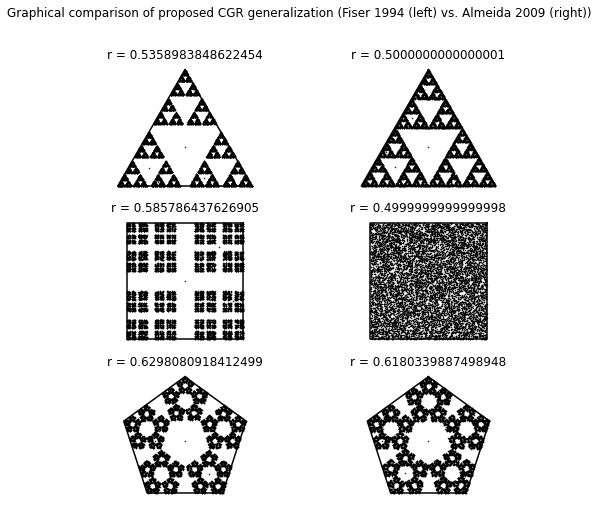

In [11]:
N = 10000

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(8, 8))
fig.suptitle('Graphical comparison of proposed CGR generalization (Fiser 1994 (left) vs. Almeida 2009 (right))')

(r, coord, points) = generalizedCGR(N, dividingRateFiser, 3, 90)
ax1.plot(coord[0, :], coord[1, :], 'k')
ax1.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax1.axis('off')
ax1.set_aspect('equal', 'box')
ax1.set_title('r = {}'.format(r))

(r, coord, points) = generalizedCGR(N, dividingRateAlmeida, 3, 90)
ax2.plot(coord[0, :], coord[1, :], 'k')
ax2.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax2.axis('off')
ax2.set_aspect('equal', 'box')
ax2.set_title('r = {}'.format(r))

(r, coord, points) = generalizedCGR(N, dividingRateFiser, 4, 45)
ax3.plot(coord[0, :], coord[1, :], 'k')
ax3.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax3.axis('off')
ax3.set_aspect('equal', 'box')
ax3.set_title('r = {}'.format(r))

(r, coord, points) = generalizedCGR(N, dividingRateAlmeida, 4, 45)
ax4.plot(coord[0, :], coord[1, :], 'k')
ax4.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax4.axis('off')
ax4.set_aspect('equal', 'box')
ax4.set_title('r = {}'.format(r))

(r, coord, points) = generalizedCGR(N, dividingRateFiser, 5, 90)
ax5.plot(coord[0, :], coord[1, :], 'k')
ax5.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax5.axis('off')
ax5.set_aspect('equal', 'box')
ax5.set_title('r = {}'.format(r))

(r, coord, points) = generalizedCGR(N, dividingRateAlmeida, 5, 90)
ax6.plot(coord[0, :], coord[1, :], 'k')
ax6.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax6.axis('off')
ax6.set_aspect('equal', 'box')
ax6.set_title('r = {}'.format(r))

plt.show()

(CGRActivity-3)=

```{admonition} CGR Activity 3
:class: tip
Using the provided code (or if you're brave, write your own), create a generalized CGR of a 6, 9, and 12-sided polygon (using the dividing rate formula by Almeida). {ref}`[What happened when we did this] <CGRActivityReport-3>`
```

In the next section, we will look at applications of CGR, mainly biological and mathematical. For the following examples, unless otherwise specified, assume that $r = 0.5$.

(sec:DNA)=
## CGR of Biological Sequences
The chaos game representation has been applied to biological areas. In this section, we will look at how the chaos game has been applied to DNA and protein (amino acids) sequencing and visualizations. We also will give a brief overview of the _Map of Life_, an extension of the visualization of DNA sequences. The Map of Life shows potential in allowing researchers to quantitatively classify species that was once unclear in its taxonomy.

### Nucleotide Sequences
H. J. Jeffrey was the first to propose using the chaos game representation as a novel way of visualizing nucleotide sequences. This revealed previously unknown patterns in certain proteins {cite:p}`jeffrey1990chaos, jeffrey1992chaos`. The genetic sequence is made up of four bases: adenine (A), guanine (G), cytosine (C), and either thymine (T) or uracil (U) for DNA or RNA, respectively. Using a square-shaped CGR, we label the four corners with the name of each base. In this paper, A is in the bottom-left corner, C in the top-left, G in the top-right, and U/T in the bottom right. Rather than use a random number generator to determine which map to use for each iteration as we did in {ref}`sec:chaos`, we follow the genetic sequence that we want to create a CGR for.

To demonstrate the chaos game for DNA sequences, let us walk through plotting the first five bases of the DNA sequence [HUMHBB](https://www.ncbi.nlm.nih.gov/nuccore/U01317.1?report=fasta) (human beta globin region, chromosome 11), "GAATT", shown in {numref}`cgr_globin`. We first mark the center as our initial point. The first base in the sequence is "G" so, we plot a point half way between our initial point and the "G" corner. The next base in the sequence is "A" so we plot a point half way between the point that we just plotted and the "A" corner. The following is the code to recreate the CGR.

In [12]:
def parse_sequence(filename):
    with open(filename) as inputfile:
        next(inputfile)
        results = list(csv.reader(inputfile))
    seq = ''
    for r in results[:-1]:
        seq = seq + r[0]
    return seq

def dna_cgr(seq):
    N = len(seq)
    dataPoints = np.zeros((2, N+1))
    dataPoints[:, 0] = np.array([0.5, 0.5])
    for i in range(1, N+1):
        if seq[i-1] == 'A':
            corner = np.array([0, 0])
        elif seq[i-1] == 'C':
            corner = np.array([0, 1])
        elif seq[i-1] == 'G':
            corner = np.array([1, 1])
        else:
            corner = np.array([1, 0])
        dataPoints[:, i] = 0.5*(dataPoints[:, i-1] + corner)
    return(dataPoints)

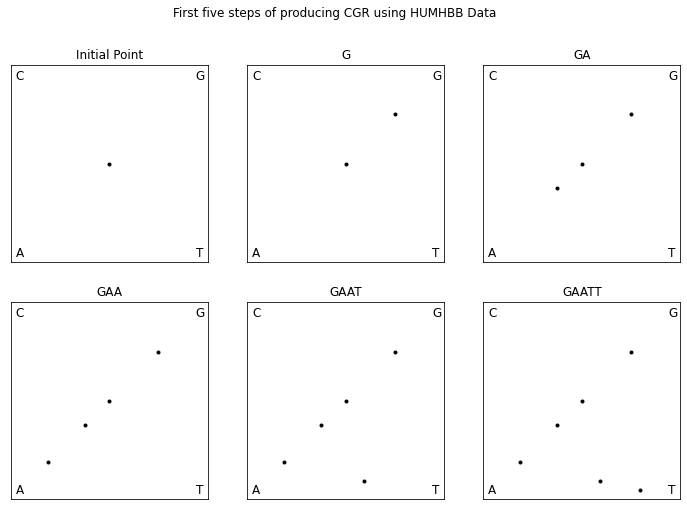

In [13]:
humhbb_dna = parse_sequence('../Supplementary Material/CGR/FASTA Files/HUMHBB.fasta')
coord = dna_cgr(humhbb_dna[:5])

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('First five steps of producing CGR using HUMHBB Data')

ax1.plot(coord[0, :1], coord[1, :1], 'k.')
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_aspect('equal', 'box')
ax1.text(0.025, 0.025, 'A', fontsize=12)
ax1.text(0.025, 0.925, 'C', fontsize=12)
ax1.text(0.94, 0.925, 'G', fontsize=12)
ax1.text(0.94, 0.025, 'T', fontsize=12)
ax1.set_title('Initial Point')

ax2.plot(coord[0, :2], coord[1, :2], 'k.')
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_aspect('equal', 'box')
ax2.text(0.025, 0.025, 'A', fontsize=12)
ax2.text(0.025, 0.925, 'C', fontsize=12)
ax2.text(0.94, 0.925, 'G', fontsize=12)
ax2.text(0.94, 0.025, 'T', fontsize=12)
ax2.set_title('G')

ax3.plot(coord[0, :3], coord[1, :3], 'k.')
ax3.axes.xaxis.set_visible(False)
ax3.axes.yaxis.set_visible(False)
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])
ax3.set_aspect('equal', 'box')
ax3.text(0.025, 0.025, 'A', fontsize=12)
ax3.text(0.025, 0.925, 'C', fontsize=12)
ax3.text(0.94, 0.925, 'G', fontsize=12)
ax3.text(0.94, 0.025, 'T', fontsize=12)
ax3.set_title('GA')

ax4.plot(coord[0, :4], coord[1, :4], 'k.')
ax4.axes.xaxis.set_visible(False)
ax4.axes.yaxis.set_visible(False)
ax4.set_xlim([0, 1])
ax4.set_ylim([0, 1])
ax4.set_aspect('equal', 'box')
ax4.text(0.025, 0.025, 'A', fontsize=12)
ax4.text(0.025, 0.925, 'C', fontsize=12)
ax4.text(0.94, 0.925, 'G', fontsize=12)
ax4.text(0.94, 0.025, 'T', fontsize=12)
ax4.set_title('GAA')

ax5.plot(coord[0, :5], coord[1, :5], 'k.')
ax5.axes.xaxis.set_visible(False)
ax5.axes.yaxis.set_visible(False)
ax5.set_xlim([0, 1])
ax5.set_ylim([0, 1])
ax5.set_aspect('equal', 'box')
ax5.text(0.025, 0.025, 'A', fontsize=12)
ax5.text(0.025, 0.925, 'C', fontsize=12)
ax5.text(0.94, 0.925, 'G', fontsize=12)
ax5.text(0.94, 0.025, 'T', fontsize=12)
ax5.set_title('GAAT')

ax6.plot(coord[0, :6], coord[1, :6], 'k.')
ax6.axes.xaxis.set_visible(False)
ax6.axes.yaxis.set_visible(False)
ax6.set_xlim([0, 1])
ax6.set_ylim([0, 1])
ax6.set_aspect('equal', 'box')
ax6.text(0.025, 0.025, 'A', fontsize=12)
ax6.text(0.025, 0.925, 'C', fontsize=12)
ax6.text(0.94, 0.925, 'G', fontsize=12)
ax6.text(0.94, 0.025, 'T', fontsize=12)
ax6.set_title('GAATT')

plt.show()

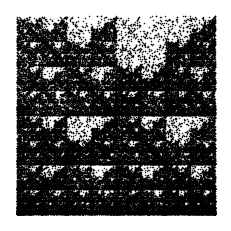

In [14]:
coord = dna_cgr(humhbb_dna)

plt.plot(coord[0, :], coord[1, :], 'k.', markersize=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.show()

The finished CGR is shown in {numref}`cgr_globin`, which certainly has an identifiable fractal pattern. The most prominent repeated pattern is the unshaded area in the top right quadrant of the figure, referred to as the "double scoop" appearance by {cite:p}`jeffrey1990chaos`, which actually appears in almost all vertebrate DNA sequences. This pattern is due to the fact that there is a comparative sparseness of guanine following cytosine in the gene sequence since CG dinucleotides are prone to methylation and subsequently mutation.

To fully understand the double scoop pattern, we must understand the biological meaning of the CGR. Each point plotted in the CGR corresponds to a base, and depending on where it is placed, we can trace back and figure out parts of the sequence we are examining {cite:p}`goldman1993nucleotide`. Figure {numref}`cgr_quadrants` shows the relationship corresponding area of the CGR and the DNA sequence. In reference to this figure, we can see that for any point that corresponds with base G, it will be located in the upper right quadrant of the CGR plot. To see what the previous base is, we can divide the quadrant into sub-quadrants (labeling them in the same order as the quadrants), and depending on where the point is, we can determine what the previous base of the sequence is. We can repeat this step again and again to find the order in which the bases appear in the sequence.  Figure {numref}`cgr_no_cg` shows a CGR square where all the CG quadrants are unfilled. We can see from this figure that even though it is not a real CGR (since we did not use a sequence to produce it), we still get the same double scoop pattern found in Figure {numref}`cgr_globin`, displayed at the beginning of the unit. By identifying regions of the CGR square in this way, it is possible to identify features of DNA sequences that correspond to patterns of the CGR.

```{figure} ../Figures/CGR/Generalized_CGR.png
---
height: 300px
name: cgr_quadrants
---
Correspondence between DNA sequences and areas of the CGR of DNA sequences
```

```{figure} ../Figures/CGR/HUMHBB_CGR.png
---
height: 300px
name: cgr_no_cg
---
Explanation of the double scoop pattern---plot of CGR square with all CG quadrants unfilled.
```

The following shows other examples of CGRs for DNA sequences. We can see that the CGR of DNA sequence of human herpesvirus strain also exhibit the double scoop pattern that we have seen for HUMHBB. This agrees with what was mentioned earlier in that it is common to see the lack of C and G dinucleotides together within the human genome. The CGR of the DNA sequence of the chloroplast of quinoa plant, on the other hand, does not show a double scoop pattern. We can see from using the CGR of DNA sequences, we are able to distinguish between different species very easily.

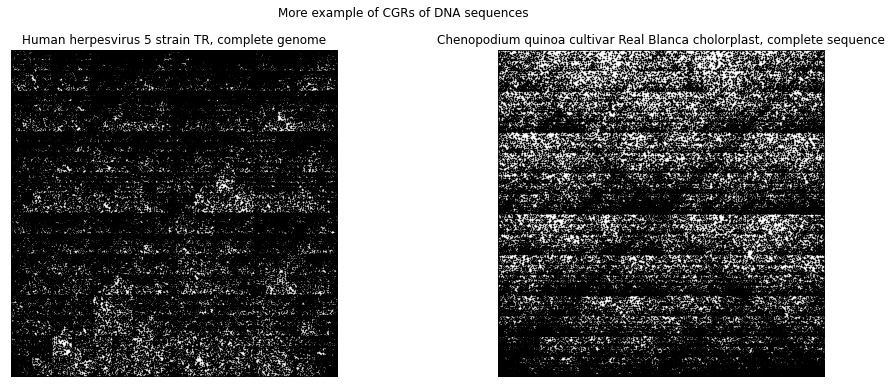

In [15]:
herpesvirus_dna = parse_sequence('../Supplementary Material/CGR/FASTA Files/KF021605.fasta')
herpesvirus_coord = dna_cgr(herpesvirus_dna)

chloroplast_dna = parse_sequence('../Supplementary Material/CGR/FASTA Files/CM008430.fasta')
chloroplast_coord = dna_cgr(chloroplast_dna)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('More example of CGRs of DNA sequences')
ax1.plot(herpesvirus_coord[0, :], herpesvirus_coord[1, :], 'k.', markersize=1)
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_aspect('equal', 'box')
ax1.set_title('Human herpesvirus 5 strain TR, complete genome')

ax2.plot(chloroplast_coord[0, :], chloroplast_coord[1, :], 'k.', markersize=1)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_aspect('equal', 'box')
ax2.set_title('Chenopodium quinoa cultivar Real Blanca cholorplast, complete sequence')

plt.show()

(CGRActivity-4)=

```{admonition} CGR Activity 4
:class: tip
Produce your own CGR of DNA sequences of your chosing. Pick sequences that are from difference species, such as plants, fungi, protists, etc. It is recommended that the length of the sequence does not exceed 50000 bp. Compare the CGRs of the difference species visually? Are there any species in which their CGRs are similar to one another? How about species in which their CGRs are most different from each other? {ref}`[What happened when we did this] <CGRActivityReport-4>`
```

### Map of Life
Taking DNA sequence visualization one step further, the authors of {cite:p}`kari2013map` proposed a novel combination of methods to create _Molecular Distance Maps_. Molecular distance maps visually illustrate the quantitative relationships and patterns of proximities among the given genetic sequences and among the species they represent. To compute and visually display relationships between DNA sequences, the three techniques that were used include chaos game representation, structural dissimilarity index (DSSIM), and multi-dimensional scaling. In the paper {cite:p}`kari2013map`, this method was applied to a variety of cases that have been historically controversial and was there demonstrated to have the potential for taxonomical clarification. In the following, we will discuss the methods used from this paper, more particularly the structural dissimilarity index and the multi-dimensional scaling as we have already looked into the chaos game representation for nucleotides.

To understand the structural dissimilarity index, we will first have to explain what the structural similarity index is. The structural similarity (SSIM) index is a method for measuring the similarity between two images based on the computation of three terms, namely luminance distortion, contrast distortion, and linear correlation {cite:p}`wang2004image`. It was designed to perform similarly to the human visual system, which is highly adapted to extract structural information. The overall index is a multiplicative combination of the three terms:
\begin{equation*}
	\operatorname{SSIM}(x, y) = [l(x, y)]^\alpha\cdot[c(x, y)]^\beta\cdot[s(x, y)]^\gamma ,
\end{equation*}
where

$$
\begin{align}
	l(x, y) &= \dfrac{2\mu_{x}\mu_{y}+C_1}{\mu_{x}^{2} + \mu_{y}^{2} + C_1} \\
	c(x, y) &= \dfrac{2\sigma_{x}\sigma_{y}+C_{2}}{\sigma_{x}^{2} + \sigma_{y}^{2} + C_2} \\
	s(x, y) &= \dfrac{\sigma_{xy} + C_{3}}{\sigma_{x}\sigma_{y} + C_{3}} ,
\end{align}
$$

where $\mu_{x}$, $\mu_{y}$, $\sigma_{x}$, $\sigma_{y}$ and $\sigma_{xy}$ are the local means, standard deviations, and cross-covariance for images $x$ and $y$. $C_{1}$, $C_{2}$, and $C_{3}$ are the regularization constants for the luminance, contrast, and structural terms, respectively. If $\alpha = \beta = \gamma = 1$, and $C_{3} = \frac{C_{2}}{2}$, the index simplifies to:
\begin{equation*}
	\operatorname{SSIM}(x, y) = \dfrac{(2\mu_{x}\mu_{y} + C_{1})(2\sigma_{xy} + C_{2})}{(\mu_{x}^{2} + \mu_{y}^{2} + C_{1})(\sigma_{x}^{2} + \sigma_{y}^{2} + C_{2})} .
\end{equation*}
The theoretical range of $\operatorname{SSIM}(x, y) \in [-1, 1]$, where the high value indicates high similarity. In {cite:p}`kari2013map`, instead of calculating the overall SSIM, they computed the local SSIM value for each pixel in the image $x$. They refer to this as a distance matrix. The SSIM index can be computed in Python by using the function `structural_similarity` from the `skimage.metrics` library.

Now that we know how to compute the SSIM index, we are able to compute the structural dissimilarity (DSSIM) index:
\begin{equation*}
	\operatorname{DSSIM}(x, y) = 1 - \operatorname{SSIM}(x, y) ,
\end{equation*}
whose theoretical range is $[0, 2]$ with the distance being 0 between two identical images, and 2 if the two images are negatively correlated. An example of two images that are negatively correlated would be if one is completely white, while the other is completely black. Typically, the range that DSSIM falls with is $[0, 1]$&mdash;the authors from {cite:p}`kari2015mapping` noted that almost all (over 5 million) distances that found were between $0$ and $1$, with only half a dozen exceptions of distances between $1$ and $1.0033$.

To demonstrate this, let us compare the "anatomically modern" human (Homo sapiens sapiens) mitochondrial DNA and the neanderthal (Homo sapiens neanderthalensis) mitochondrial DNA (mtDNA). As seen from their scientific classification, we can see that these two species are from the same genus, which suggests that their DNA should be similar. The following shows the CGRs of the "anatomically modern" human (left) and of the neanderthal (right). We can see that the two CGRs are quite similar (which is agrees with the fact that the two species are from the same genus) and therefore, we expect the the DSSIM to be small.

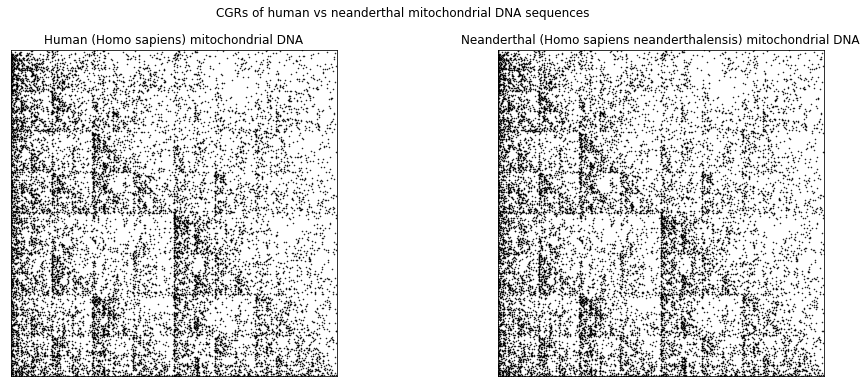

In [16]:
human_dna = parse_sequence('../Supplementary Material/CGR/FASTA Files/NC_012920.fasta')
human_coord = dna_cgr(human_dna)

neanderthal_dna = parse_sequence('../Supplementary Material/CGR/FASTA Files/NC_011137.fasta')
neanderthal_coord = dna_cgr(neanderthal_dna)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('CGRs of human vs neanderthal mitochondrial DNA sequences')
ax1.plot(human_coord[0, :], human_coord[1, :], 'k.', markersize=1)
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_aspect('equal', 'box')
ax1.set_title('Human (Homo sapiens) mitochondrial DNA')

ax2.plot(neanderthal_coord[0, :], neanderthal_coord[1, :], 'k.', markersize=1)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_aspect('equal', 'box')
ax2.set_title('Neanderthal (Homo sapiens neanderthalensis) mitochondrial DNA')

plt.show()

In Python, in order to compare these two plots, we first need to convert each plot into a matrix. The size of the matrix is determined by the dimension of the plot (number of pixels), and each element within the matrix represents each pixel in the plot, where $0$ represents a white pixel, $1$ represents a black pixel, and any value in between represents a pixel that is a shade of grey. The simplest way to convert the plot to a matrix is to first save the image as a .png file. In the following code block, we show the way that we like to save the figures&mdash;the additional settings in the `savefig()` call removes the white border around the plot.

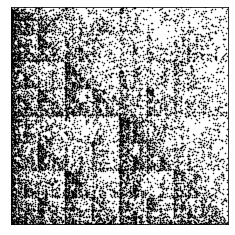

In [17]:
# In order to find SSIM, need to save figures as an image file. 
# Below is an example of how you would save your figures as a png file.
plt.plot(human_coord[0, :], human_coord[1, :], 'k.', markersize=1)
plt.xticks([])
plt.yticks([])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', 'box')
plt.savefig('../Supplementary Material/CGR/Output/human.png', bbox_inches='tight', pad_inches=0)

Once we have saved the images as a .png file, we use Python's `skimage.io.imread()` function to read in the images as matrices. We also specify in the parameters of this function that this image is greyscale, which returns an $m\times n$ matrix ($m$ and $n$ are dependent on the dimensions of the image). If the parameter `as_gray` was not set to `True`, then the output would be a $m \times n \times 3$, which accounts for the different color channels (RGB).

In [18]:
human_CGR = skimage.io.imread('../Supplementary Material/CGR/Output/human.png', as_gray=True)
neanderthal_CGR = skimage.io.imread('../Supplementary Material/CGR/Output/neanderthal.png', as_gray=True)

Now that the two images have been converted to matrices, we use Python's `structural_similarity` function from the `skimage.metrics` library (aliased as `ssim` below) and calculate the structural similarity index between the two images.

In [19]:
human_neanderthal_ssim = ssim(human_CGR, neanderthal_CGR)
print(human_neanderthal_ssim)

0.8968926645376541


and therefore, the structural dissimilarity index is then

In [20]:
1 - human_neanderthal_ssim

0.10310733546234585

which agrees with our expectations.

In the following, we look at another example that compares the mtDNA of humans to other species, such as the great spotted kiwi (left) and pearlfish (right).

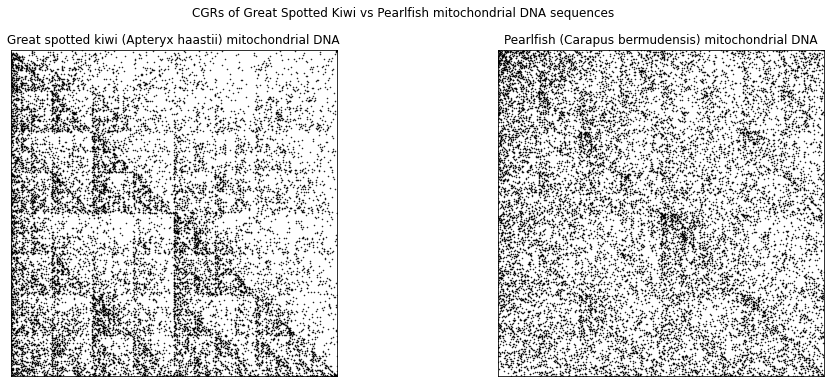

In [21]:
kiwi_dna = parse_sequence('../Supplementary Material/CGR/FASTA Files/NC_002782.fasta')
kiwi_coord = dna_cgr(kiwi_dna)

pearlfish_dna = parse_sequence('../Supplementary Material/CGR/FASTA Files/NC_004373.fasta')
pearlfish_coord = dna_cgr(pearlfish_dna)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('CGRs of Great Spotted Kiwi vs Pearlfish mitochondrial DNA sequences')
ax1.plot(kiwi_coord[0, :], kiwi_coord[1, :], 'k.', markersize=1)
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_aspect('equal', 'box')
ax1.set_title('Great spotted kiwi (Apteryx haastii) mitochondrial DNA')

ax2.plot(pearlfish_coord[0, :], pearlfish_coord[1, :], 'k.', markersize=1)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_aspect('equal', 'box')
ax2.set_title('Pearlfish (Carapus bermudensis) mitochondrial DNA')

plt.show()

Just visually, the CGR of the mtDNA of the great spotted kiwi looks more similar to the CGRs of the human and neanderthal than the CGR of the pearlfish. Using all of the DSSIM, we can produce what is called a distance matrix, which is a square, real, symmetric matrix where each element is the structural dissimilarity index of two species with corresponds to the row and column. The distance matrix for the four species that we have already produced the CGR for is

<!-- $$
    \mathrm{DSSIM}(x, y) =
    \begin{bmatrix}
        0 & 0.1223 & 0.7823 & 0.8541 \\
        0.1223 & 0 & 0.7821 & 0.8533 \\
        0.7823 & 0.7821 & 0 & 0.8519 \\
        0.8541 & 0.8533 & 0.8519 & 0
    \end{bmatrix} ,
$$ -->

In [22]:
def dist_matrix(cgr_list):
    n = len(cgr_list)
    dmat = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dmat[i, j] = 1 - ssim(cgr_list[i], cgr_list[j])
            dmat[j, i] = dmat[i, j]
    return(dmat)

In [23]:
kiwi_CGR = skimage.io.imread('../Supplementary Material/CGR/Output/greatspottedkiwi.png', as_gray=True)
pearlfish_CGR = skimage.io.imread('../Supplementary Material/CGR/Output/pearlfish.png', as_gray=True)

CGR_list = [human_CGR, neanderthal_CGR, kiwi_CGR, pearlfish_CGR]

dssim = dist_matrix(CGR_list)
dssim

array([[0.        , 0.10310734, 0.76524434, 0.85537312],
       [0.10310734, 0.        , 0.76727659, 0.85644889],
       [0.76524434, 0.76727659, 0.        , 0.85483255],
       [0.85537312, 0.85644889, 0.85483255, 0.        ]])

where the first row/column represents humans, the second row/column represents the neanderthals, the third row/column represents the great spotted kiwi, and lastly, the fourth row/column represents the pearlfish. Obviously, the diagonal of the matrix would be $0$, since the DSSIM of two of the same images would produce a result of 0. As we have seen previously, the $\mathrm{DSSIM}(\mathrm{human},\ \mathrm{neanderthal}) = 0.10310734$, and vice versa. From this matrix, we can see that the CGR of the mtDNA of pearlfish is most different than the rest&mdash;this agrees with what we have observed.

Multi-dimensional scaling (MDS) is a means of visualizing the level of similarity or dissimilarity of individual case of a dataset. It has been used in various fields such as cognitive science, information science, pychometrics, marketing, ecology, social science and other areas of study {cite:p}`borg2005modern`. The goal of MDS is to find a spatial configuration of objects when all that is known is some measure of their general similarity or dissimilarity {cite:p}`wickelmaier2003introduction`. Here, the MDS takes in the distance matrix (of size $n$ by $n$) and outputs a $n$ by $p$ configuration matrix, where each row of this matrix represents the coordinates of the item in $p$ dimension. In this unit, we will only be looking at $p = 2$ and $p = 3$ as it is difficult to create visualization in dimensions greater than 3. In {cite:p}`kari2013map`, the authors used a classical MDS, which assumes that all the distances (from the distance matrix) are Euclidean. For the algorithm for classical MDS, refer to {cite:p}`wickelmaier2003introduction`(p. 10). Although Python's `scikit-learn` library has a MDS function (`sklearn.manifold.MDS()`), we provide a different function that performs classical multidimensional scaling below. The following function computes the coordinates of the points under the new map much quicker than the MDS function in the `scikit-learn` library.

In [24]:
# Function taken from https://pyseer.readthedocs.io/en/master/_modules/pyseer/cmdscale.html
def cmdscale(D):
    """Classical multidimensional scaling (MDS)

    Args:
        D (numpy.array)
            Symmetric distance matrix (n, n)

    Returns:
        Y (numpy.array)
            Configuration matrix (n, p). Each column represents a dimension. Only the
            p dimensions corresponding to positive eigenvalues of B are returned.
            Note that each dimension is only determined up to an overall sign,
            corresponding to a reflection.
        e (numpy.array)
            Eigenvalues of B (n, 1)
    """
    # Number of points
    n = len(D)

    # Centering matrix
    H = np.eye(n) - np.ones((n, n))/n

    # YY^T
    B = -H.dot(D**2).dot(H)/2

    # Diagonalize
    evals, evecs = np.linalg.eigh(B)

    # Sort by eigenvalue in descending order
    idx = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]

    # Compute the coordinates using positive-eigenvalued components only
    w, = np.where(evals > 0)
    L = np.diag(np.sqrt(evals[w]))
    V = evecs[:, w]
    Y = V.dot(L)

    return Y, evals[evals > 0]

We perform the classical MDS on the dissimilarity matrix `dssim` calculated above. Even though the `cmdscale` function returns two outputs, we only require the first output (the configuration matrix) for our visualization. We can also converted the matrix into a pandas dataframe to clarify which row corresponds which animal.

In [25]:
Y, _ = cmdscale(dssim)
Y_df = pd.DataFrame(data=Y, columns = ['x', 'y', 'z'])
Y_df['animal'] = ['human', 'neanderthal', 'great spotted kiwi', 'pearlfish']
Y_df

,x,y,z,animal
0,-0.326245,0.107564,0.051616,human
1,-0.327661,0.109078,-0.051471,neanderthal
2,0.143462,-0.494346,-0.000133,great spotted kiwi
3,0.510445,0.277704,-0.000012,pearlfish


To plot the points in in 2 dimensions, we use the first two columns as our $x$ and $y$ coordinates, respectively. Here, we decide to use the `seaborn` data visualization library (which is based on `matplotlib`) as this library specializes in dealing with data stored in a dataframe.

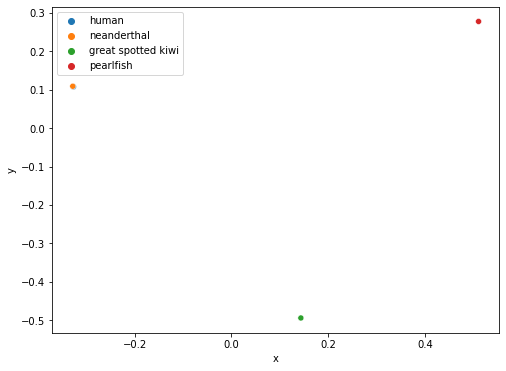

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
sns.scatterplot(x='x', y='y', hue='animal', data=Y_df)
legend = ax.legend()
plt.show()

From the plot above, we are able to observe the degree of difference between the four CGRs by the distance between the four points. Since the human and neanderthal points overlap each other, this indicates that their CGRs are very similar, thus implying that the mtDNA of human and neanderthals are also similar. If we were interested in knowing whether humans are more similar to the great spotted kiwi or pearlfish, we can easily see from the plot above that humans are closer related to the great spotted kiwi genetically since the distance between the human and great spotted kiwi points are closer than the distance between the human and pearlfish points.

Now that we understand the idea of using classical multidimensional scaling, we can apply this method to a large set of animals (in this case 4844). This will allow us to visualize how similar the animals are genetically to each other, which could potentially help with classifying animals in which their class is ambiguous.

Since it takes an extremely long time to calculate the dissimilarity matrix for 4844 vertebrate animals (it took us around 8 hours to compute the dissimilarity matrix in parallel with 12 threads, using an AMD Ryzen 5 3600X 6-Core Processor), we have already calculated it for you and provided the data file, which can be found in the `Supplementary Material` folder in our Github repository. The code used to create the dissimilarity matrix is provided in the `code` folder of our repository (read the `README.md` file for instructions on the order to run the code). Now, let us apply the classical MDS to the dissimilarity matrix provided.

In [27]:
# Load list of animals and their classes. This will be used to colour the points on the scatter plot
file = open("../Supplementary Material/CGR/Data Files/animal_class.pkl", "rb")
animal_list = pickle.load(file)
file.close()
animal_class = list(animal_list.values())

In [28]:
DSSIM = np.load('../Supplementary Material/CGR/Data Files/DSSIM_matrix.dat', allow_pickle=True)
coord, _ = cmdscale(DSSIM)
coord_splice = coord[:, :3]
cmdscaling_df = pd.DataFrame(data = coord_splice, columns = ['x', 'y', 'z'])
cmdscaling_df['class'] = animal_class
cmdscaling_df.head()

,x,y,z,class
0,-0.044784,-0.017598,0.023091,amphibians
1,-0.040420,0.012079,0.012869,amphibians
2,-0.044732,-0.027890,0.028080,amphibians
3,-0.023975,0.015180,0.030752,amphibians
4,-0.053848,-0.068480,0.015756,amphibians


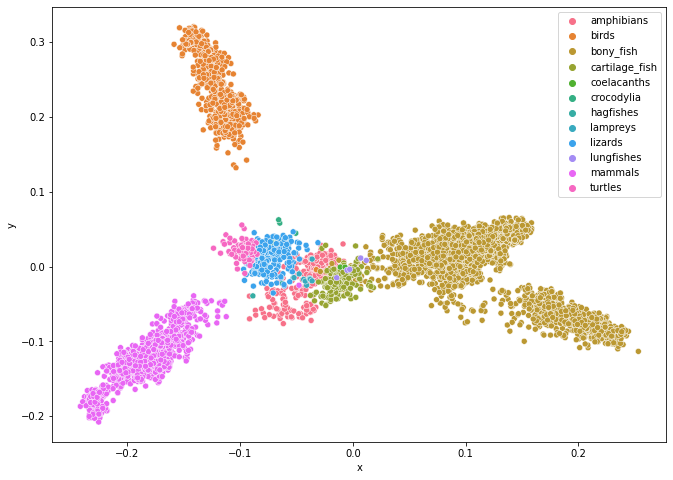

In [29]:
fig = plt.figure(figsize=(11, 8))
ax = sns.scatterplot(x='x', y='y', hue='class', data=cmdscaling_df)
legend = ax.legend()
plt.show()

The plot above shows a molecular distance map of 4844 animals from various classes from the chordate phylum (meaning that all these animals have a vertebrate), coloured according to their class. The sequences were taken from NCBI Reference Sequence Database (RefSeq). We can see from this figure that this method (Map of Life) does quite a good job in sorting species into different categories. One particular aspect that we want to point out in this figure is where the points representing the lungfish are&mdash;they are in the area of where the bony fish, cartilage fish, and amphibians touch. This is truly remarkable as lung fish has qualities of all these classes.

Since the points overlap one another, we could also plot the points in 3 dimensions.

In [30]:
# Since for 3D scatter plot, we need to plot each class of animals separately, we pre-assign colours to each animal class
animal_class_unique = cmdscaling_df['class'].unique()
cmap = sns.color_palette("husl", 12)

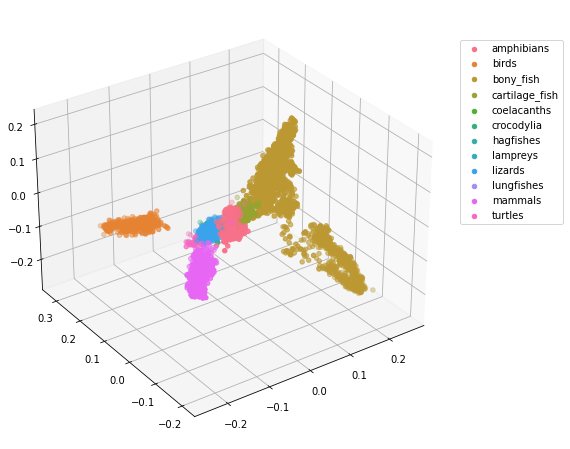

In [31]:
# %matplotlib notebook
fig = plt.figure(figsize=(11, 8))
ax = plt.axes(projection = '3d')
fig.add_axes(ax)
for i in range(len(animal_class_unique)):
    data = cmdscaling_df.loc[cmdscaling_df['class'] == animal_class_unique[i]]
    ax.scatter(data['x'], data['y'], data['z'], label=animal_class_unique[i], color=cmap[i])
ax.view_init(30, -125)
plt.legend(loc=(1.04,0.5))
plt.show()

_If you are viewing this in jupyter notebook, uncomment the first line of the previous code block and rerun the code block. This will allow you to rotate the 3D plot above! (Before moving on to the following code blocks run the line `%matplotlib inline` again so that the following plots will render within the notebook.)_

If you are curious as to how to use the `sklearn.manifold.MDS()` function, the code for multidimensional scaling for the 4844 vertebrates is given in the following code block. _Warning:_ if you are not performing the following code block in parallel, it will take around half an hour to complete. Additionally, since our `DSSIM` variable is already a dissimilarity matrix, we set the parameter `dissimilarity` in our `sklearn.manifold.MDS()` class to `precomputed`. However, be aware that the dissimilarity matrix `DSSIM` is not Euclidean, and therefore, the results using the `sklearn.maifold.MDS()` class will differ from the results shown previously.

In [32]:
md_scaling = manifold.MDS(n_components=2, dissimilarity='precomputed', random_state=0, n_jobs=mp.cpu_count())
coord = md_scaling.fit_transform(DSSIM)
mdscaling_df = pd.DataFrame(data = coord, columns = ['x', 'y'])
mdscaling_df['class'] = animal_class
mdscaling_df.head()

,x,y,class
0,-0.425241,0.569110,amphibians
1,0.712073,0.134961,amphibians
2,-0.660362,-0.025253,amphibians
3,0.703996,0.048820,amphibians
4,-0.589360,0.044000,amphibians


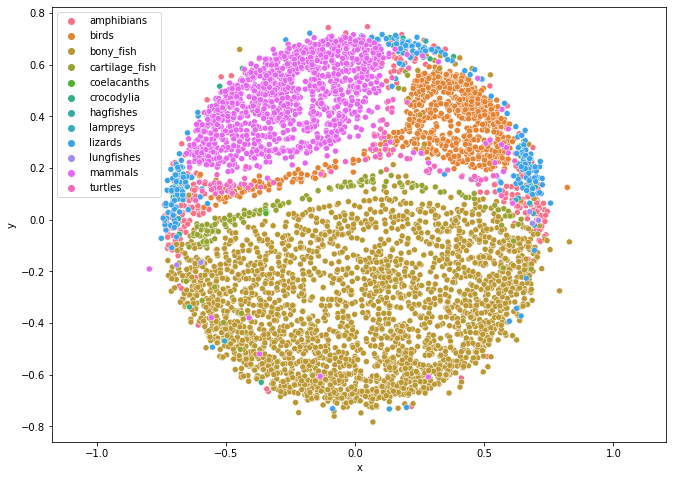

In [33]:
fig = plt.figure()
fig.set_size_inches(11, 8)
ax = sns.scatterplot(x='x', y='y', hue='class', data=mdscaling_df)
legend = ax.legend()
plt.axis('equal')
plt.show()

Although the results from using the `sklearn.manifold.MDS()` class differs from the result from the `cmdscale()` function, we observe that this plot is still able to group the animals by class quite well.

(CGRActivity-5)=

```{admonition} CGR Activity 5
:class: tip
Create a molecular distance map of the mitochondrion DNA of molluscs. The Fasta files are provided to you and can be found in the `Supplementary Material/CGR/Activities/Molluscs/Fasta Files` folder. {ref}`[What happened when we did this] <CGRActivityReport-5>`
```

### Protein Visualization
CGR has also been applied to visualizing and analyzing both the primary and secondary structures of proteins. The primary structure of a protein is simply an amino acid sequence. To analyze the primary structure of proteins, the authors from {cite:p}`fiser1994chaos` using an $20$-sided regular polygon, each representing an amino acid. {numref}`amino_acid` shows all 20 amino acids along with their 3-letter code, as well as their 1-letter code. To avoid the attractor from overlapping itself, we will use the dividing rate for a $20$-gon shown from {cite:p}`almeida2009biological`, $r = 0.863271$. Some CGRs for protein visualizations can be found in the following.

```{table} Table of all 20 amino acids
:name: amino_acid
| Name          | 3 letter code | 1 letter code |
|---------------|---------------|---------------|
| alanine       | ala           | A             |
| arginine      | arg           | R             |
| asparagine    | asn           | N             |
| aspartic acid | asp           | D             |
| cysteine      | cys           | C             |
| glutamine     | gln           | Q             |
| glutamic acid | glu           | E             |
| glycine       | gly           | G             |
| histidine     | his           | H             |
| isoleucine    | ile           | I             |
| leucine       | leu           | L             |
| lysine        | lys           | K             |
| methionine    | met           | M             |
| phenylalanine | phe           | F             |
| proline       | pro           | P             |
| serine        | ser           | S             |
| threonine     | thre          | T             |
| tryptophan    | trp           | W             |
| tyrosine      | tyr           | Y             |
| valine        | val           | V             |
```

In [34]:
def protein_cgr(seq):
    N = len(seq)
    AA = 'ARNDCQEGHILKMFPSTWYVBZ'
    # B = Aspartic acid (D) or Asparagine (N)
    # Z = Glutamic acid (E) or Glutamine (Q)
    vertices = n_gon(20, 90)
    r = dividingRateAlmeida(20)
    dataPoints = np.zeros((2, N+1))
    for i in range(1, N+1):
        index = AA.index(seq[i-1])
        if index == 20:
            r = random.randint(0, 1)
            if r == 0:
                index = AA.index('D')
            else:
                index = AA.index('N')
        elif index == 21:
            r = random.randint(0, 1)
            if r == 0:
                index = AA.index('E')
            else:
                index = AA.index('Q')
        dataPoints[:, i] = dataPoints[:, i-1] + (vertices[:, index] - dataPoints[:, i-1])*r
    return(vertices, dataPoints)

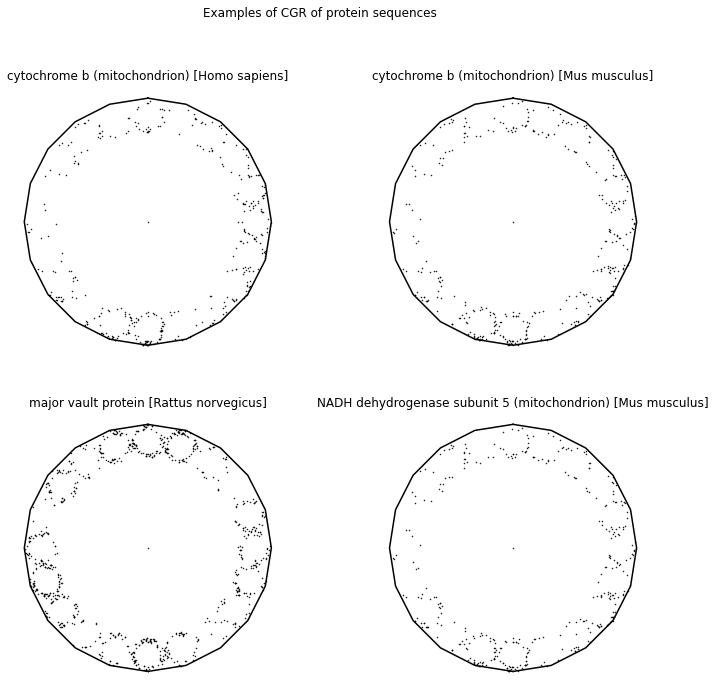

In [35]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 11))
fig.suptitle('Examples of CGR of protein sequences')

human_cytochrome_b_seq = parse_sequence('../Supplementary Material/CGR/FASTA Files/ASY00349.fasta')
(coord, points) = protein_cgr(human_cytochrome_b_seq)
ax1.plot(coord[0, :], coord[1, :], 'k')
ax1.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax1.axis('off')
ax1.set_aspect('equal', 'box')
ax1.set_title('cytochrome b (mitochondrion) [Homo sapiens]')

mouse_cytochrome_b_seq = parse_sequence('../Supplementary Material/CGR/FASTA Files/NP_904340.fasta')
(coord, points) = protein_cgr(mouse_cytochrome_b_seq)
ax2.plot(coord[0, :], coord[1, :], 'k')
ax2.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax2.axis('off')
ax2.set_aspect('equal', 'box')
ax2.set_title('cytochrome b (mitochondrion) [Mus musculus]')

major_vault_protein_seq = parse_sequence('../Supplementary Material/CGR/FASTA Files/NP_073206.fasta')
(coord, points) = protein_cgr(major_vault_protein_seq)
ax3.plot(coord[0, :], coord[1, :], 'k')
ax3.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax3.axis('off')
ax3.set_aspect('equal', 'box')
ax3.set_title('major vault protein [Rattus norvegicus]')

NADH_dehydrogenase_seq = parse_sequence('../Supplementary Material/CGR/FASTA Files/NP_904340.fasta')
(coord, points) = protein_cgr(NADH_dehydrogenase_seq)
ax4.plot(coord[0, :], coord[1, :], 'k')
ax4.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax4.axis('off')
ax4.set_aspect('equal', 'box')
ax4.set_title('NADH dehydrogenase subunit 5 (mitochondrion) [Mus musculus]')

plt.show()

(CGRActivity-6)=

```{admonition} CGR Activity 6
:class: tip
Create a molecular distance map of the cytochrome b (mitochondrion) protein in all land plants. Fasta files are located in the `Supplementary Material/CGR/Activities/Land Plants/Fasta Files` folder. {ref}`[What happened when we did this] <CGRActivityReport-6>`
```

According to Basu et al. {cite:p}`basu1997chaos`, there are two serious limitations for using a 20-vertex CGR to identify patterns. The first limitation the authors mentioned about using the 20-vertex is that it is hard to visualize different protein families since one would have to plot the sequences in different polygons rather than plotting a random sampling of proteins of different functions and origins in a single CGR {cite:p}`fiser1994chaos`. The second limitation is that there the amino acid residues in different positions are often replaced by similar amino acids {cite:p}`basu1997chaos`. This means that the 20-vertex CGR cannot be used to differentiate between similar and dissimilar residues and the visualization could be different for proteins within the same family.

To fix the second limitation mentioned in {cite:p}`basu1997chaos`, Fiser et al. {cite:p}`fiser1994chaos` introduced using CGR to study 3D structures of proteins. A chain of amino acid is what is called a polypeptide. Due to each amino acid having a specific structure, which contributes to the amino acid's properties, such as hydrophobicity or hydrogen-bonding, depending on the sequence of the amino acid chain, the polypeptide chain will fold into its lowest energy configuration {cite:p}`simon1991calculation`.
This is known as the secondary structure. The two most common structures that appear in this stage are the $\alpha$-helices and the $\beta$-sheets. Using the chaos game on the secondary structure can indicate any non-randomness of the structural elements in proteins. One way to achieve this is to divide the 20 amino acids into 4 groups based on different properties and assign each group to a corner. Some properties that have been considered for CGR include hydrophobicity, molecular weight, isoelectric point (pI), $\alpha$ propensity, and $\beta$ propensity. For details, see {cite:p}`basu1997chaos, fiser1994chaos`.

(sec:math)=
## CGR of Mathematical Sequences
In the first-year course we gave in 2015 {cite:p}`chan2018random`, we applied the chaos game representation to mathematical sequences found on the Online Encyclopedia of Integer Sequences (OEIS) {cite:p}`oeis`. In the following, we show some CGR experiments that came from the first-year course. Some sequences that were used from the Online Encyclopedia of Integer Sequences (OEIS) included digits of $\pi$ (A000796), Fibonacci Numbers (A000045), prime numbers (A000040), and some from the continued fractions section (which were introduced at the beginning of the course). We will not only look at the visualizations created in the first-year course, but we will also determine whether these experiments are considered to be good visual representations. 

<!-- Note that for the following 4-vertex examples, the vertices are labeled from "0" to "3" starting from the bottom left corner of the plot going clockwise (i.e. "0" corresponds to the coordinate point $(-1, -1)$, "1" corresponds to the point $(-1, 1)$, etc.).  -->

### Digits of Pi
We first applied CGR to the digits of $\pi$ (A000796 from the [OEIS](https://oeis.org/A000796)), since we believe that the sequence of the digits are random[^6]. Since we focused on the 4-vertex CGR in the course, we na&iuml;vely took the digits of $\pi$ modulo 4 and applied it to the 4-vertex CGR. The result of this is shown in the left figure below. Since we assumed that the digits of $\pi$ are random, this means that the visualization should be similar to the square-shaped CGR of random integer sequences from {ref}`sec:polygons`. However, we can see that this is not the case; instead of a uniform covering of the space, we can see a pattern of vertical lines occurring. Quantitatively, the DSSIM index between the CGR of the digits of $\pi$ modulo 4 and the CGR of random digits is $0.9851$, which indicates that they are not similar. The reason for this is because when we take $10\bmod{4}$, the values are distributed to the corners unevenly: our 0 and 1 vertices would have one extra value each, and thus why our CGR of the digits of $\pi$ does not match the CGR of random integers even though we know for a fact that the digits of $\pi$ are indeed random. Due to this reason, the left figure below is not a good visual representation of the digits of $\pi$.

However, there are solutions to this problem. Through personal communication, Lila Kari suggested reading 2 digits of $\pi$ at a time (i.e. the first few 2-digit number of $\pi$ would be $14$, $15$, $92$, etc.). As the smallest and largest possible number would be 0 and 99, respectively, this means that there are 100 possible combinations, and therefore 100 different numbers. Therefore, since 100 is divisible by 4, this means that we can group the numbers evenly into 4 groups, whether it is by taking the modulo (base 4) of the numbers, or dividing the numbers by the groups 0-24, 25-49, 50-74, and 75-99. We leave this as an exercise for the reader.

Another solution to this is to visualize the digits of $\pi$ is shown in the right figure below. We use a 10-vertex CGR ($r = 0.763932$) where each vertex represents an integer from 0 to 9. From this figure, we can see that the points produce a fractal pattern of the decagon, which suggests that the sequence is random.

In [36]:
def pi_digits(n):
    S = str(sympy.N(sympy.pi, n+1))
    return(list(map(int, list(S[2:]))))    

In [37]:
def numeric_cgr(seq, n_ver, *start):
    N = len(seq)
    if start:
        vertices = n_gon(n_ver, start[0])
    else:
        vertices = n_gon(n_ver, 0)
    r = dividingRateAlmeida(n_ver)
    dataPoints = np.zeros((2, N+1))
    for i in range(1, N+1):
        index = seq[i-1]%n_ver
        dataPoints[:, i] = dataPoints[:, i-1] + (vertices[:, index] - dataPoints[:, i-1])*r
    return(vertices, dataPoints)

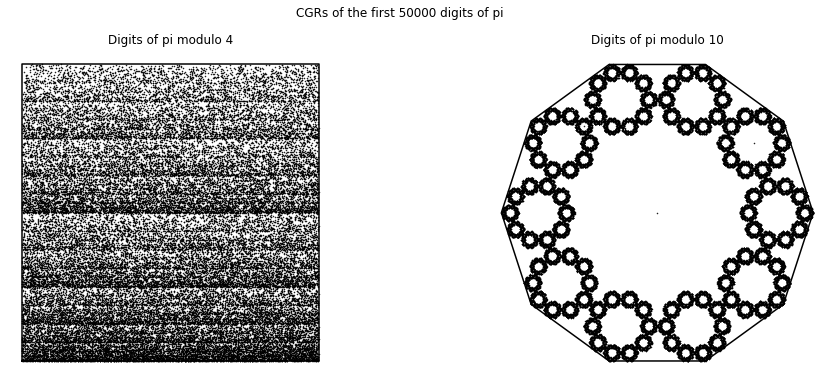

In [38]:
N = 50000
pi_seq = pi_digits(N)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('CGRs of the first {} digits of pi'.format(N))
(coord, points) = numeric_cgr(pi_seq, 4, -135)
ax1.plot(coord[0, :], coord[1, :], 'k')
ax1.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax1.axis('off')
ax1.set_aspect('equal', 'box')
ax1.set_title('Digits of pi modulo 4')

(coord, points) = numeric_cgr(pi_seq, 10)
ax2.plot(coord[0, :], coord[1, :], 'k')
ax2.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax2.axis('off')
ax2.set_aspect('equal', 'box')
ax2.set_title('Digits of pi modulo 10')

plt.show()

(CGRActivity-7)=

```{admonition} CGR Activity 7
:class: tip
Create a square CGR for the digits of $pi$ by reading 2 digits at a time (as explained above). Assign the two-digit numbers a corner by the following two methods:

a) taking the modulo (base 4) and assigning the corners 0, 1, 2, 3 {ref}`[What happened when we did this] <CGRActivityReport-7a>`

b) assigning the corners to cover the values 0-24, 25-49, 50-74, and 75-99, respectively. {ref}`[What happened when we did this] <CGRActivityReport-7b>`

c) Do the CGRs look different from one another? What conclusions can you draw from the two CGRs? {ref}`[What happened when we did this] <CGRActivityReport-7c>`
```

(CGRActivity-8)=

```{admonition} CGR Activity 8
:class: tip
Repeat the above exercise with the digits of $e = 2.71828...$ {ref}`[What happened when we did this] <CGRActivityReport-8>`
```

### Fibonacci Sequence
We also created a visualization of the Fibonacci Sequence (A000045 from the OEIS). One example of a visualization of this sequence is a 10-vertex CGR of the Fibonacci sequence modulo 10; that is, a sequence of the final digits of $F_n$. It appears by the density of the even blocks in {numref}`cgr_Fibonacci_wrong` that most (by far and away most) of the numbers of the Fibonacci sequence are even; this conclusion seems very strange, and deserves a closer look.

In fact the sequence is ultimately periodic (as of course it must be, because the set of decimal digits is finite), and indeed it has period $60$: The first $65$ entries are $1, 1, 2, 3, 5, 8, 3, 1, \ldots, 9, 1, 0, 1, 1, 2, 3, 5$ and it repeats from there.  Just by counting, $40$ out of these $60$ numbers are _odd_, and only $20$ are even; so the conclusion that "almost all Fibonacci numbers are even" that we drew from {numref}`cgr_Fibonacci_wrong` is completely wrong!

```{figure} ../Figures/CGR/FibonacciCGRmod10crop.png
---
height: 300px
name: cgr_Fibonacci_wrong
---
CGR of the Fibonacci sequence calculated in floating-point arithmetic before taking the remainder mod 10 in Matlab
```

The correct behaviour is shown below; this shows the periodicity by its sparseness.  It is important to do the modular reduction as you go, if you are working in floating-point arithmetic; once $F_n$ gets large enough it won't be possible to compute the trailing digit correctly and all one will see is rounding error, which we see in {numref}`cgr_Fibonacci_wrong` looks pretty uniform on each _even_ block. In contrast, while a pair of floating-point integers (called a "flints" in some places) remains small, arithmetic with it remains perfectly accurate. What we are seeing in the figure is an effect of rounding errors in _large_ floating-point integers; more, a closer look at $f_{79}$ shows the _round-to-even_ rule for IEEE floating-point arithmetic[^7]. Since $f_{78}$ really is even, and $f_{79}$ is rounded to an even number by the round-to-even rule, all computed floating-point Fibonacci numbers thereafter are even. Of course, once they got large enough that the units place falls completely off the significand, they would all be reported as "even" anyway.

In [39]:
def fibonacci(n, mod=False):
    if n == 1:
        return([0])
    elif n == 2:
        return([0, 1])
    else:
        seq = [0, 1]
        for i in range(2, n):
            n_element = seq[i-2] + seq[i-1]
            if mod:
                n_element = n_element%10
            seq.append(n_element)
        return(seq)

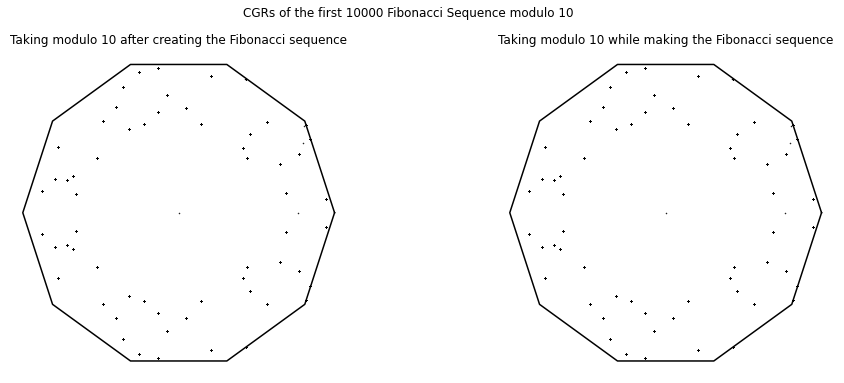

In [40]:
N = 10000

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('CGRs of the first {} Fibonacci Sequence modulo 10'.format(N))
fib_seq = fibonacci(N)
(coord, points) = numeric_cgr(fib_seq, 10)
ax1.plot(coord[0, :], coord[1, :], 'k')
ax1.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax1.axis('off')
ax1.set_aspect('equal', 'box')
ax1.set_title('Taking modulo 10 after creating the Fibonacci sequence')

fib_seq_mod10 = fibonacci(N, mod=True)
(coord, points) = numeric_cgr(fib_seq, 10)
ax2.plot(coord[0, :], coord[1, :], 'k')
ax2.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax2.axis('off')
ax2.set_aspect('equal', 'box')
ax2.set_title('Taking modulo 10 while making the Fibonacci sequence')

plt.show()

Other visualizations for the Fibonacci sequence can be done, such as taking the remainder using a different divisor and using a CGR with different number of vertices.

However, since the Fibonacci sequence grows very quickly, like $\phi^n$ where $\phi = (1+\sqrt{5})/2 \doteq 1.618$ is the golden ratio, the students also learned about another limitation of floating point since they were unable to take more than the first 3000 Fibonacci numbers before the computation overflow, registering the number as infinity. Using big integers instead as is possible in Python, overflow wouldn't happen (as seen above), but the arithmetic would get slower.

### Prime Numbers
Following the visualization of the digits of $\pi$ and the Fibonacci sequence using the chaos game, we looked at another popular sequence: the sequence of prime numbers ([A000040 from the OEIS](https://oeis.org/A000040)). We looked at four different ways of creating the CGR for prime numbers. 

We first visualized the prime numbers in a similar way as what we did for the digits of $\pi$ and the Fibonacci numbers by taking the sequence of prime numbers modulo 10. This is shown in the top left figure below. We notice that almost all of the prime numbers ends with a 1, 3, 7, or 9. Because of this observation, we decided to create a square CGR labelling the vertices with these values. The result is shown in the top right figure below.

The bottom left figure is the third visualization of prime numbers: a CGR of the $103+k$th prime numbers $\bmod\ 4$, a diagonal line which spans from the "1" corner to the "3" corner. As we all know, prime numbers larger than 2 will never be even, so the corner points "0" and "2" which are representative "even" values would never occur, thus creating a straight diagonal line. If we had reassigned the values the coordinate points represent, the plot would have turned out differently; instead of a diagonal line, it could possibly be a horizontal (spanning from coordinate points $(-1, -1)$ to $(1, -1)$ or from $(-1, 1)$ to $(1, 1)$) or vertical line (spanning from $(-1, 1)$ to $(-1, -1)$ or $(1, 1)$ to $(1, -1)$), or a diagonal line the spanning the other two vertices. One needs to be mindful of how the coordinate points are assigned.

Lastly, we can visualize the prime numbers in a different way, as seen in the bottom right figure. Here, we took the sequence of prime numbers less than one million and took $\bmod\ 8$ of the numbers. We thought that this would be interesting because taking any prime number larger than $2$ modulo $8$ will only result in the following numbers: 1, 3, 5, and 7. Because of this, we relabelled the vertices to "1", "3", "5", and "7" starting from the bottom left corner, going clockwise (i.e. the coordinate point $(-1, -1)$ is labelled "1", $(-1, 1)$ is labelled "3", etc.), and plotted the points according to the chaos game ($r = 0.5$). Surprisingly, this gives us a pattern, apparently meaning that there is a pattern in the sequence of prime numbers $\bmod\ 8$. However, compare this to a random-populated square CGR, which, though random, showed patterns. This "evidence of pattern" is not conclusive! This is possibly simply a Procrustean effect, and we'd have to know more about the distribution of primes to say more.

In [41]:
def primes(N):
    # returns list of prime numbers less than or equal to N
    seq = []
    for i in range(2, N+1):
        divisor = 0
        for j in range(2, i):
            if i%j == 0:
                divisor += 1
        if divisor == 0 or i == 2:
            seq.append(i)
    return(seq)

def numeric_cgr_vertex(seq, vertex, *start):
    N = len(seq)
    n_ver = len(vertex)
    if start:
        vertices = n_gon(n_ver, start[0])
    else:
        vertices = n_gon(n_ver, 0)
    r = dividingRateAlmeida(n_ver)
    dataPoints = np.zeros((2, N+1))
    for i in range(1, N+1):
        index = vertex.index(seq[i-1])
        dataPoints[:, i] = dataPoints[:, i-1] + (vertices[:, index] - dataPoints[:, i-1])*r
    return(vertices, dataPoints)

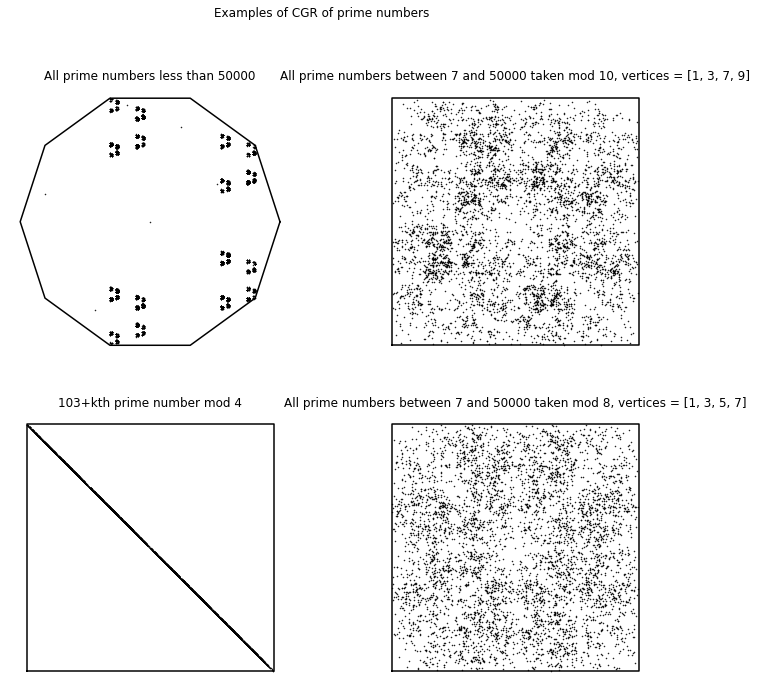

In [42]:
N = 50000

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 11))
fig.suptitle('Examples of CGR of prime numbers')

prime_num = primes(N)
(coord, points) = numeric_cgr(prime_num, 10)
ax1.plot(coord[0, :], coord[1, :], 'k')
ax1.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax1.axis('off')
ax1.set_aspect('equal', 'box')
ax1.set_title('All prime numbers less than {}'.format(N))

prime_num_mod10 = [p%10 for p in prime_num]
(coord, points) = numeric_cgr_vertex(prime_num_mod10[3:], [1, 3, 7, 9], -135)
ax2.plot(coord[0, :], coord[1, :], 'k')
ax2.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax2.axis('off')
ax2.set_aspect('equal', 'box')
ax2.set_title('All prime numbers between 7 and {} taken mod 10, vertices = [1, 3, 7, 9]'.format(N))

prime_num_mod4 = [p%4 for p in prime_num]
(coord, points) = numeric_cgr(prime_num_mod4[102:], 4, -135)
ax3.plot(coord[0, :], coord[1, :], 'k')
ax3.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax3.axis('off')
ax3.set_aspect('equal', 'box')
ax3.set_title('103+kth prime number mod 4')

prime_num_mod8 = [p%8 for p in prime_num]
(coord, points) = numeric_cgr_vertex(prime_num_mod8[3:], [1, 3, 5, 7], -135)
ax4.plot(coord[0, :], coord[1, :], 'k')
ax4.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax4.axis('off')
ax4.set_aspect('equal', 'box')
ax4.set_title('All prime numbers between 7 and {} taken mod 8, vertices = [1, 3, 5, 7]'.format(N))

plt.show()

### Partial Quotients of Continued Fractions
We then explored visualizing the sequences taken from the partial quotients of continued fractions, which were taught at the beginning of the course. Continued fractions are fractions written in the following general form {cite:p}`olds1963continued, Corless1992`:
\begin{equation}
	a_0 + \cfrac{1}{a_{1} + \cfrac{1}{a_{2} + \cfrac{1}{a_{3} + \cfrac{1}{a_{4} + \cfrac{1}{\ddots}}}}} ,
\end{equation}
which produces a sequence of numbers, $a_{0} + \left[ a_{1}, a_{2}, a_{3}, a_{4}, \cdots\right]$, called the partial quotients of the continued fraction. This can be demonstrated with an example: we can rewrite $\frac{9}{7}$ in the form
\begin{equation}
	\dfrac{9}{7} = 1 + \dfrac{2}{7} = 1 + \dfrac{1}{\frac{7}{2}} = 1 + \cfrac{1}{3 + \frac{1}{2}} = 1 + \dfrac{1}{3 + \cfrac{1}{1 + \frac{1}{1}}} .
	\label{eqn:cfrac}
\end{equation}
Here, the partial quotients of $\frac{9}{7}$ are the elements of $1 + \left[3, 1, 1\right]$. The students then looked at the continued fractions of other numbers, such as $\sqrt{2}$, $e$ and $\pi$, where the sequences of their partial quotients were used in chaos game representations.

One recurring theme of the experimental mathematics course was $\sqrt{2}$, so with this in mind, some students jumped on the opportunity to plot the chaos game representation of the quotients of the continued fraction of $\sqrt{2}$. As we had seen in an earlier unit, the sequence goes like
\begin{equation*}
	1 + [2, 2, 2, 2, \ldots, 2] .
\end{equation*}
Because all elements of the sequence (apart from the first one) are 2's, it is not surprising to see a (faint) diagonal line with most of the points in the upper right corner, shown in the left figure below. The students also tried the partial quotients of $e$, which is equal to
\begin{equation*}
	2 + \left[1, 2, 1, 1, 4, 1, 1, 6, \cdots \right]
\end{equation*}
{cite:p}`olds1970simple`, shown in the middle figure. What is seen here makes sense as the sequence mostly contains 1's and these alternates with even values, so in this case, either 0 or 2. Therefore, it is clear that there are no points in the lower right corner since that represents the value 3. Unfortunately, these two plots do not look all that impressive; in fact, it is pretty underwhelming. Disappointed with this result, the students decided to experiment with other sequences in which all four coordinates occur.

The students then thought, "Why not take the partial quotients of the continued fraction of $\pi$? The results _must_ be random." As shown in the right figure, unexpectedly, there is indeed a pattern, which shows that the sequence of partial quotients of the continued fraction of $\pi$ is not as random as we thought at the beginning of the course. This showed the students that the distribution is not uniform.

In [43]:
def confrac(expr, n):
    result = []
    for i, v in enumerate(continued_fraction_iterator(expr)):
        if i > (n-1):
            break
        result.append(v)
    return(result)

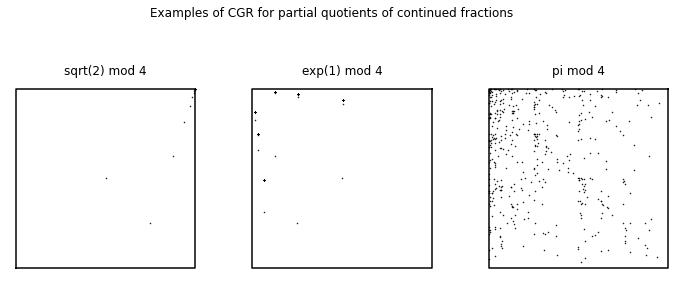

In [44]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle('Examples of CGR for partial quotients of continued fractions')

pq_sqrt2 = confrac(sympy.sqrt(2), 200)
(coord, points) = numeric_cgr(pq_sqrt2, 4, -135)
ax1.plot(coord[0, :], coord[1, :], 'k')
ax1.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax1.axis('off')
ax1.set_aspect('equal', 'box')
ax1.set_title('sqrt(2) mod 4')

pq_exp = confrac(sympy.exp(1), 200)
(coord, points) = numeric_cgr(pq_exp, 4, 45)
ax2.plot(coord[0, :], coord[1, :], 'k')
ax2.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax2.axis('off')
ax2.set_aspect('equal', 'box')
ax2.set_title('exp(1) mod 4')

pq_pi = confrac(sympy.pi, 450)
(coord, points) = numeric_cgr(pq_pi, 4, 45)
ax3.plot(coord[0, :], coord[1, :], 'k')
ax3.plot(points[0, :], points[1, :], 'k.', markersize=1)
ax3.axis('off')
ax3.set_aspect('equal', 'box')
ax3.set_title('pi mod 4')

plt.show()

In fact, the distribution of partial quotients is very well known, owing to the results of Khinchin {cite:p}`khinchin1964continued`. As a very startling aside, recently, Bill Gosper has remarked on an amazing identity
\begin{equation}
	\prod k!^{\Delta_{3}\ln k} = K^{\ln 2} ,
\end{equation}
where $K$ is Khinchin's constant. We did not inform our students of Khinchin's remarkable results because CGR was only done at the end of the course. Next time, perhaps!

(CGRActivity-9)=

```{admonition} CGR Activity 9
:class: tip
Create another CGR using the partial quotients of a continued fraction of any irrational number of your choosing. Feel free to use CGRs with different number of vertices or grouping the numbers in different ways (such as what we did for the digits of $\pi$ in a previous activity). {ref}`[What happened when we did this] <CGRActivityReport-9>`
```

(sec:random)=
## Random vs Pseudorandom
The theory of probability arose much later in the development of science than the theory of dynamical systems and of exact trajectories, and therefore, it may be more difficult to grasp. There are many different works on the fundamentals of probability which discuss this difficulty; see for instance {cite:p}`hamming1991art`, but also {cite:p}`kac1959probability`. We believe that combining deterministic dynamics with randomness is even more difficult; and that this, in fact, is the main business nowadays of the applied mathematician.  There have been, of course, millions of words written on the topic.  We believe that it is crucial that entering students see some of the discussions of the fundamentals; they need to have a chance to grasp the deeper, most practical aspects of the theory.  We believe that this module offers the instructor a chance to begin those discussions.

One important early part of the discussion is whether or not what the computer produces is "really" random, and whether entries in a sequence are "really" independent.  We alluded earlier to the fact that the poor quality of some early bad random number generators was detected by patterns arising in two-dimensional pictures.  How are the patterns arising in the pictures in this paper different?  Would they arise if "really" random numbers were used instead of the pseudorandom numbers generated by computer? [The answer is yes.]  And what is the difference, anyway?  There are knots here that the students (and professors) can tie themselves in: once a sequence of numbers is written down, however randomly it was generated, how can it be random, any more?  It's now perfectly predictable!  The most comforting words that we know about this come from Kolmogorov himself (quoted in full at the end of this paper) which we paraphrase as "it's only a model". Indeed see {cite:p}`kolmogorov1983logical` for a brief discussion of a _mathematical_ foundation for probability. This applies whether your sequence is "really" random, or only "pseudo" random.

These discussions are important, in a situation such as that of this paper, where we are trying to tease out deterministic aspects of _apparently_ random sequences (or of sequences such as that of DNA which is surely influenced both by random events (mutation, horizontal gene transfer) and very non-random events (selection)).  We have used some "clearly" non-random (in some sense) sequences such as the digits of $\pi$ to show that we can detect a signature of randomness there; we have used the same techniques to detect a signature of regularity. To be convinced, the students must be allowed to discuss these issues at some length. In particular, this may be the first time the students have encountered pseudorandom numbers.

There are several high-quality methods for uniform pseudorandom number generation: the most popular includes the _multiple-recursive method_ and families formed by _shift-register methods_ {cite:p}`dennis2015princeton`. The multiple-recursive method is an extension of the linear congruential method by replacing the first-order linear recursion by one of higher order. One family in the shift-register method generates uniform pseudorandom numbers by means of linear recurring sequences modulo $2$. Another uses vector recursions modulo $2$ of higher order; this family includes the very popular Mersenne twister MT19937 {cite:p}`matsumoto1998mersenne`, which is the default for Python's pseudorandom number generating library [`random`](https://docs.python.org/3/library/random.html), which includes `random.random()` (which returns a random floating point number in the range $[0.0, 1.0)$), `random.uniform(a, b)` (which returns a random floating point number between $a$ and $b$), and `random.randint(a,b)` (which returns a random integer in the range $[a, b]$).

As mentioned above, Python's `random` library uses is the Mersenne twister MT19937 to generate uniform pseudorandom numbers. The MT19937 produces sequences of uniform pseudorandom numbers with period length $2^{19937} - 1$ that possess 623-dimensional equidistribution up to 32 bits accuracy {cite:p}`dennis2015princeton`. This would seem to create a better "random" outcome in comparison to an actual sequence of die rolls according to some measures. However, [random.org](https://www.random.org/) claims that their "dice roller" is, for many purposes, better than pseudorandom number algorithms typically used in computer programs. The randomness in their program comes from atmospheric noise.  

Using a pseudorandom number generator differs to using dice or the atmospheric-sourced generators at [random.org](https://www.random.org/). One gets different results due to the different methods that are used. Now, physically-based systems that we believe are random are sometimes more problematic than we think. For instance, rolling a die is not quite as random as one would expect. Stein's article {cite:p}`stein2012dice` in Inside Science states that dice rolls are not completely random: the initial position of the (fair) die affects the outcome of the die roll. And is anything in the atmosphere truly random?  Or is this just a statement of our ignorance?  Kolmogorov's words&mdash;it's only a model&mdash;are comforting here. But they help with the use of pseudorandom numbers, as well.

In practice, pseudorandom number generators are indispensable for working with probability, and an enormous amount of work has gone into making them of very high-quality indeed.  We know of no way to distinguish&mdash;in practice&mdash;results from these good generators from results given by physically-based generators that nearly everyone believes are "really" random.

## Concluding Remarks
This module can be used to teach students about a useful visualization of sequences, in which case the emphasis from the instructor could be on interpreting the results, perhaps by using structural similarity or distance maps. The module can also be used to teach elementary programming techniques, in which case the instructor can emphasize programming tools, correctness, efficiency, style, or analysis.

Using elementary sequences of integers makes the module accessible even to first-year students, avoiding difficult biological details: but even so, students are exposed to the deep concepts of pattern and randomness more or less straight away. We have only begun a discussion of what it means to be random, and what it means to have a pattern. Randomness in a model can be a way to hide our ignorance, or it can be a profound statement of our understanding. Modelling viral evolution using randomness {cite:p}`wahl2017prophage`, where mutations occur in large populations, is clearly warranted; similarly for the vast lengths of DNA sequences. For prime numbers, in one sense clearly not: primes cannot be random, even though they behave in some ways as if they are.

```{epigraph}
Such considerations may be repeated as often as we like, but it is clear that this procedure will never allow us to be free of the necessity, at the last stage, of referring to probabilities in the primitive imprecise sense of this term.

It would be quite wrong to think that difficulties of this kind are peculiar in some way to the theory of probability. In the mathematical investigation of actual events, we always make a model of them. The discrepancies between the actual course of events and the theoretical model can, in its turn, be made the subject of mathematical investigation. But for these discrepancies we must construct a model that we will use without formal mathematical analysis of the discrepancies which again would arise in it in actual experiment.

-- [Andrey Kolmogorov](https://mathshistory.st-andrews.ac.uk/Biographies/Kolmogorov/), {cite:p}`aleksandrov1999mathematics`

```

Indeed, much the same comments can be made about our use of the words "fractal" and "attractor" here.  All of our computations are finite, so _nothing_ that we see is actually a "true fractal", and similarly our computations show only  parts of the transients, not the attracting set (much less the attractor). This doesn't matter: again, what matters is that fractals and attractors, in the infinite limit, provide good models for the pictures that our finite computations produce.  For more details both about the rigour and the utility of fractals, consult {cite:p}`mandelbrot2013fractals`.  As a final remark, what convinced us of the value of CGR for DNA sequences was nothing mathematical, but rather its wonderfully apropos placement of curious creatures on the "Map of Life": for instance, picking out an organism mapped to a point near the border between the group of "fish" and the group  of "amphibians" we find an air-breathing fish!

This raises a final point. This technique really works, for DNA sequences; and it can be genuinely informative for other kinds of sequences, as we have seen.  For instance, we were able to detect the influence of rounding errors (for the Fibonacci sequence computation).  One also needs an explanation of _why_ this works; these can make good discussion points with students.  Consider the impact of short stretches of so-called "junk" or non-coding DNA, distributed throughout a long coding sequence.  Will the "junk" make a difference to the CGR representation? In some cases not, but if there is enough junk, then maybe it will.  But in many cases we could claim that one reason this works is that CGR really gives a "whole picture" of the sequence, and is relatively robust under errors such as shifts and interruptions with short insertions.  Then one should investigate that claim, to see if it was true.

[^1]: To be more specific, this is a _hyperbolic_ iterated function system. However, the word "hyperbolic" is sometimes dropped in practice {cite:p}`barnsley2014fractals`(p. 82).

[^2]: It can be proved that in the limit of infinite computation for a random sequence of infinite length that the picture really is that of the Sierpinski triangle {cite:p}`barnsley2011chaos`.

[^3]: The word "game" here does not refer to an adversarial game with choices and strategies as in _game theory_, but instead treats sequences as something like the outcomes of a game of chance like tossing coins. The use of "chaos" here happened because the biologist H.J. Jeffrey used the word, likely to indicate generally from which area of mathematics the ideas were taken from.

[^4]: We tried this, though not in class. We got up to 80 points on one figure, using the die roller on [random.org](https://www.random.org/). It's kind of fun, in a physical "drawing and measuring" way, but it's hard not to make mistakes. It could make a useful "active learning" exercise and we might try it in class in the future.

[^5]: This is a loose way of thinking about it: we somehow imagine regions of the gameboard that equally attract elements of the sequence, and if these regions overlap, then we see spuriously dense regions on the gameboard.  Alternatively, we could think (more rigorously) about the _probability measure_ of the attractor (now really spread over the whole gameboard).  One would want a "random" sequence to have a uniform measure across the gameboard.

[^6]: {cite:p}`Aragon_Artacho2013-am` performed a deterministic walk over the digits of $\pi$ and compared it visually with pseudorandom walks of the same length to determine whether the digits of $\pi$ are random. See their paper for details (and their pretty visualizations of their walk over the digits of $\pi$).

[^7]: The round-to-even rule is a topic that many students stumble over. As is pointed out in {cite:p}`Higham2002`(Section 1.17), rounding errors are not random; but the round-to-even rule was invented to reduce the _bias_ of rounding error in long sequences of computation. This sounds paradoxical but although rounding errors are not random, or independent, there are situations where it is a useful model to assume so: see {cite:p}`Higham2002`(Section 2.8) for further discussion of this point.